In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.stats.distributions as dist
from matplotlib.colors import LogNorm

In [2]:
CNN_csv = 'CNN_info_V4.parquet'
CNN_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/'
real_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/IMG_dir/REAL_FITS_11_04v2_dir/'
df_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/DF_dir/'
objects_df = pd.read_parquet(df_dir + 'objects_master_22_10_28.parquet')
cnn_run_table = pd.read_parquet(CNN_dir + CNN_csv)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cnn_run_table[cnn_run_table.boost_massive_gals == 'True'])

     RUN_ID  N_EPOCHS  PIX_SCALE    TH_OPT  TH_OPT_F1   TRA_ACC   VAL_ACC  \
42       85        50         50  0.507508   0.315315  0.798700  0.780255   
43       86        50         50  0.461461   0.325325  0.809070  0.802158   
44       87        50         50  0.491491   0.374374  0.718616  0.690616   
45       88        50         50  0.511512   0.328328  0.712443  0.697343   
46       89        50         50  0.421421   0.291291  0.742265  0.736991   
47       90        50         50  0.449449   0.307307  0.738763  0.722778   
48       91        50         50  0.443443   0.235235  0.729087  0.717482   
49       92        50         50  0.489489   0.229229  0.712567  0.705539   
50       93        50         50  0.594595   0.474474  0.729896  0.717615   
51       94        50         50  0.549550   0.500501  0.726543  0.716965   
52       95        50         50  0.541542   0.342342  0.741041  0.720371   
53       96        50         50  0.486486   0.333333  0.754450  0.747315   

In [3]:
def load_results(run_ids):
    output = {}
    for run_id in run_ids:
        results = pd.read_parquet('/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d/' %(run_id) + 'full_subhalo_results.parquet')
        output[run_id] = results
    run_info = cnn_run_table[cnn_run_table.RUN_ID.isin(run_ids)] 
    
    return output, run_info

results_list, run_info = load_results([42, 72, 93, 94, 115,117, 111])
results_list, run_info = load_results([329,326, 237, 247])


for results in results_list.values():
    results['Mass/radius**2'] = results['Mstellar'] / results['HMRad'] ** 2
    results['SFR/Mass'] = results['SFR']/results['Mstellar']

In [4]:
params = ['Mstellar', 'HMRad', 'Edd_ratio', 'Mass/radius**2', 'SFR/Mass']

no_log = ['Redshift', 'ratio_recent', 'Z', 'ratio_recent', 'dt_recent', 'ratio_biggest', 'dt_biggest','GAS_FRAC']

scale = {'Mstellar': 1e10, 'MDM': 1e10, 'Mgas': 1e10, 'HMRad': 1, 'MBH': 1e10, 'BHacc' : 1e10, 'SFR' : 1, 'HMRad' : 1, 'edd_ratio' : 1, 'Edd_ratio' : 1, 'Mass/radius**2' : 1, 'SFR/Mass' :1}
xlabels = {'Mstellar' : 'log_10(Mstellar)', 'Redshift' : 'Redshift', 'HMRad' : 'log_10(Half Mass Radius [kpc])', 'edd_ratio':'log10(Eddington Ratio)', 'Edd_ratio':'log10(Eddington Ratio)', 'Mass/radius**2' : 'log10(Mass/radius**2)', 'SFR/Mass':'SFR/Mass'}
title_labels = {0: '(No boosting or HMrad matching)', 1: '(No boosting or HMrad matching)' , 2: '(High M boosting)', 3: '(High M boosting)', 4: '(Boosting and HMrad matching)', 5: '(Boosting and HMrad matching)', 6: '(Boosting and HMrad matching)'}


def plot_multi_results(results_list, params, no_log):
    
    for param in params:
        
        fig = plt.figure(figsize = (15,6 * len(results_list)))
        ax = fig.subplots(len(results_list),2)
        
        probs = []
        
        for i, results in enumerate(results_list):
            
            if param == 'Edd_ratio':
                results = results.loc[results['Edd_ratio'] > 1e-6]
            
            error_bars = []

            if param in no_log:
                counts_M_total, edges_M, bars = ax[i,0].hist(results.loc[results['LABEL'] == 1][param].values, bins = 15, histtype = 'step', label = 'Post Mergers')
                counts_M, edges, bars = ax[i,0].hist(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)][param].values, bins = edges_M, histtype = 'step', label = 'TP')
                counts_NM_total, edges_NM, bars = ax[i,0].hist(results.loc[results['LABEL'] == 0][param].values, bins = edges_M, histtype = 'step', label = 'Controls')
                counts_NM, edges, bars = ax[i,0].hist(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][param].values, bins = edges_M, histtype = 'step', label = 'TN')

            else:

                results_M_total = np.log10(results.loc[results['LABEL'] == 1][param].values * scale[param])
                results_M = np.log10(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)][param].values * scale[param])
                results_NM_total = np.log10(results.loc[results['LABEL'] == 0][param].values * scale[param])
                results_NM = np.log10(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][param].values * scale[param])

                results_M_total[results_M_total == -np.inf] = 0
                results_M[results_M == -np.inf] = 0
                results_NM_total[results_NM_total == -np.inf] = 0
                results_NM[results_NM == -np.inf] = 0
                
                counts_M_total, edges_M, bars = ax[i,0].hist(results_M_total, bins = 15, histtype = 'step', label = 'Post Mergers')
                counts_M, edges, bars = ax[i,0].hist(results_M, bins = edges_M, histtype = 'step', label = 'TP')
                counts_NM_total, edges_NM, bars = ax[i,0].hist(results_NM_total, bins = edges_M, histtype = 'step', label = 'Controls')
                counts_NM, edges, bars = ax[i,0].hist(results_NM, bins = edges_M, histtype = 'step', label = 'TN')

            if param not in no_log:
                edges_M = 10**(edges_M-10)

            c = 0.683
            k_M, k_NM = counts_M, counts_NM
            n_M, n_NM = counts_M_total, counts_NM_total
            p_M_lower, p_NM_lower = dist.beta.ppf((1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf((1-c)/2.,k_NM+1,n_NM-k_NM+1)
            p_M_upper, p_NM_upper = dist.beta.ppf(1-(1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf(1-(1-c)/2.,k_NM+1,n_NM-k_NM+1)



            probs_M_total = []
            probs_M = []
            probs_NM_total = []
            probs_NM = []
            bin_edges = []

            for j in range(len(edges_M) - 1):
                probs_M_total.append(results.loc[(results['LABEL'] == 1) & (results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_M.append(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)].loc[(results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_NM_total.append(results.loc[(results['LABEL'] == 0) & (results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_NM.append(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)].loc[(results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                bin_edges.append(np.array([edges_M[j], edges_M[j + 1]]))

            
            
            ax[i,0].set_title(param + ' distribution' + ' %s'%(title_labels[i]))
            ax[i,0].set_ylabel('# counts')
            ax[i,0].set_xlabel(xlabels[param])
            ax[i,0].legend()
            
            probs.append([probs_M_total, probs_M, probs_NM_total, probs_NM, bin_edges])


            centers = 0.5*(edges[1:]+ edges[:-1])
            
            yerr_low = p_M_lower - counts_M/counts_M_total
            yerr_up = p_M_upper - counts_M/counts_M_total 
            yerr_low[yerr_low > 0] = 0
            yerr_up[yerr_up < 0] = 0
            
            yerr = np.absolute(np.array([yerr_low, yerr_up]))
            ax[i,1].errorbar(centers, counts_M/counts_M_total, yerr = yerr, fmt = '.-', label = 'PM')

            yerr_low = p_NM_lower - counts_NM/counts_NM_total
            yerr_up = p_NM_upper - counts_NM/counts_NM_total 
            yerr_low[yerr_low > 0] = 0
            yerr_up[yerr_up < 0] = 0
            yerr = np.absolute(np.array([yerr_low, yerr_up]))

            ax[i,1].errorbar(centers, counts_NM/counts_NM_total, yerr = yerr , fmt = '.-', label = 'Controls')
            
            ax[i,1].set_ylabel('Fraction correctly identified')
            ax[i,1].set_title('Correct fraction binned by ' + param + ' %s'%(title_labels[i]))
            ax[i,1].set_ylim(0, 1.05)
            ax[i,1].set_xlabel(xlabels[param])
            ax[i,1].legend()

        plt.tight_layout()

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide

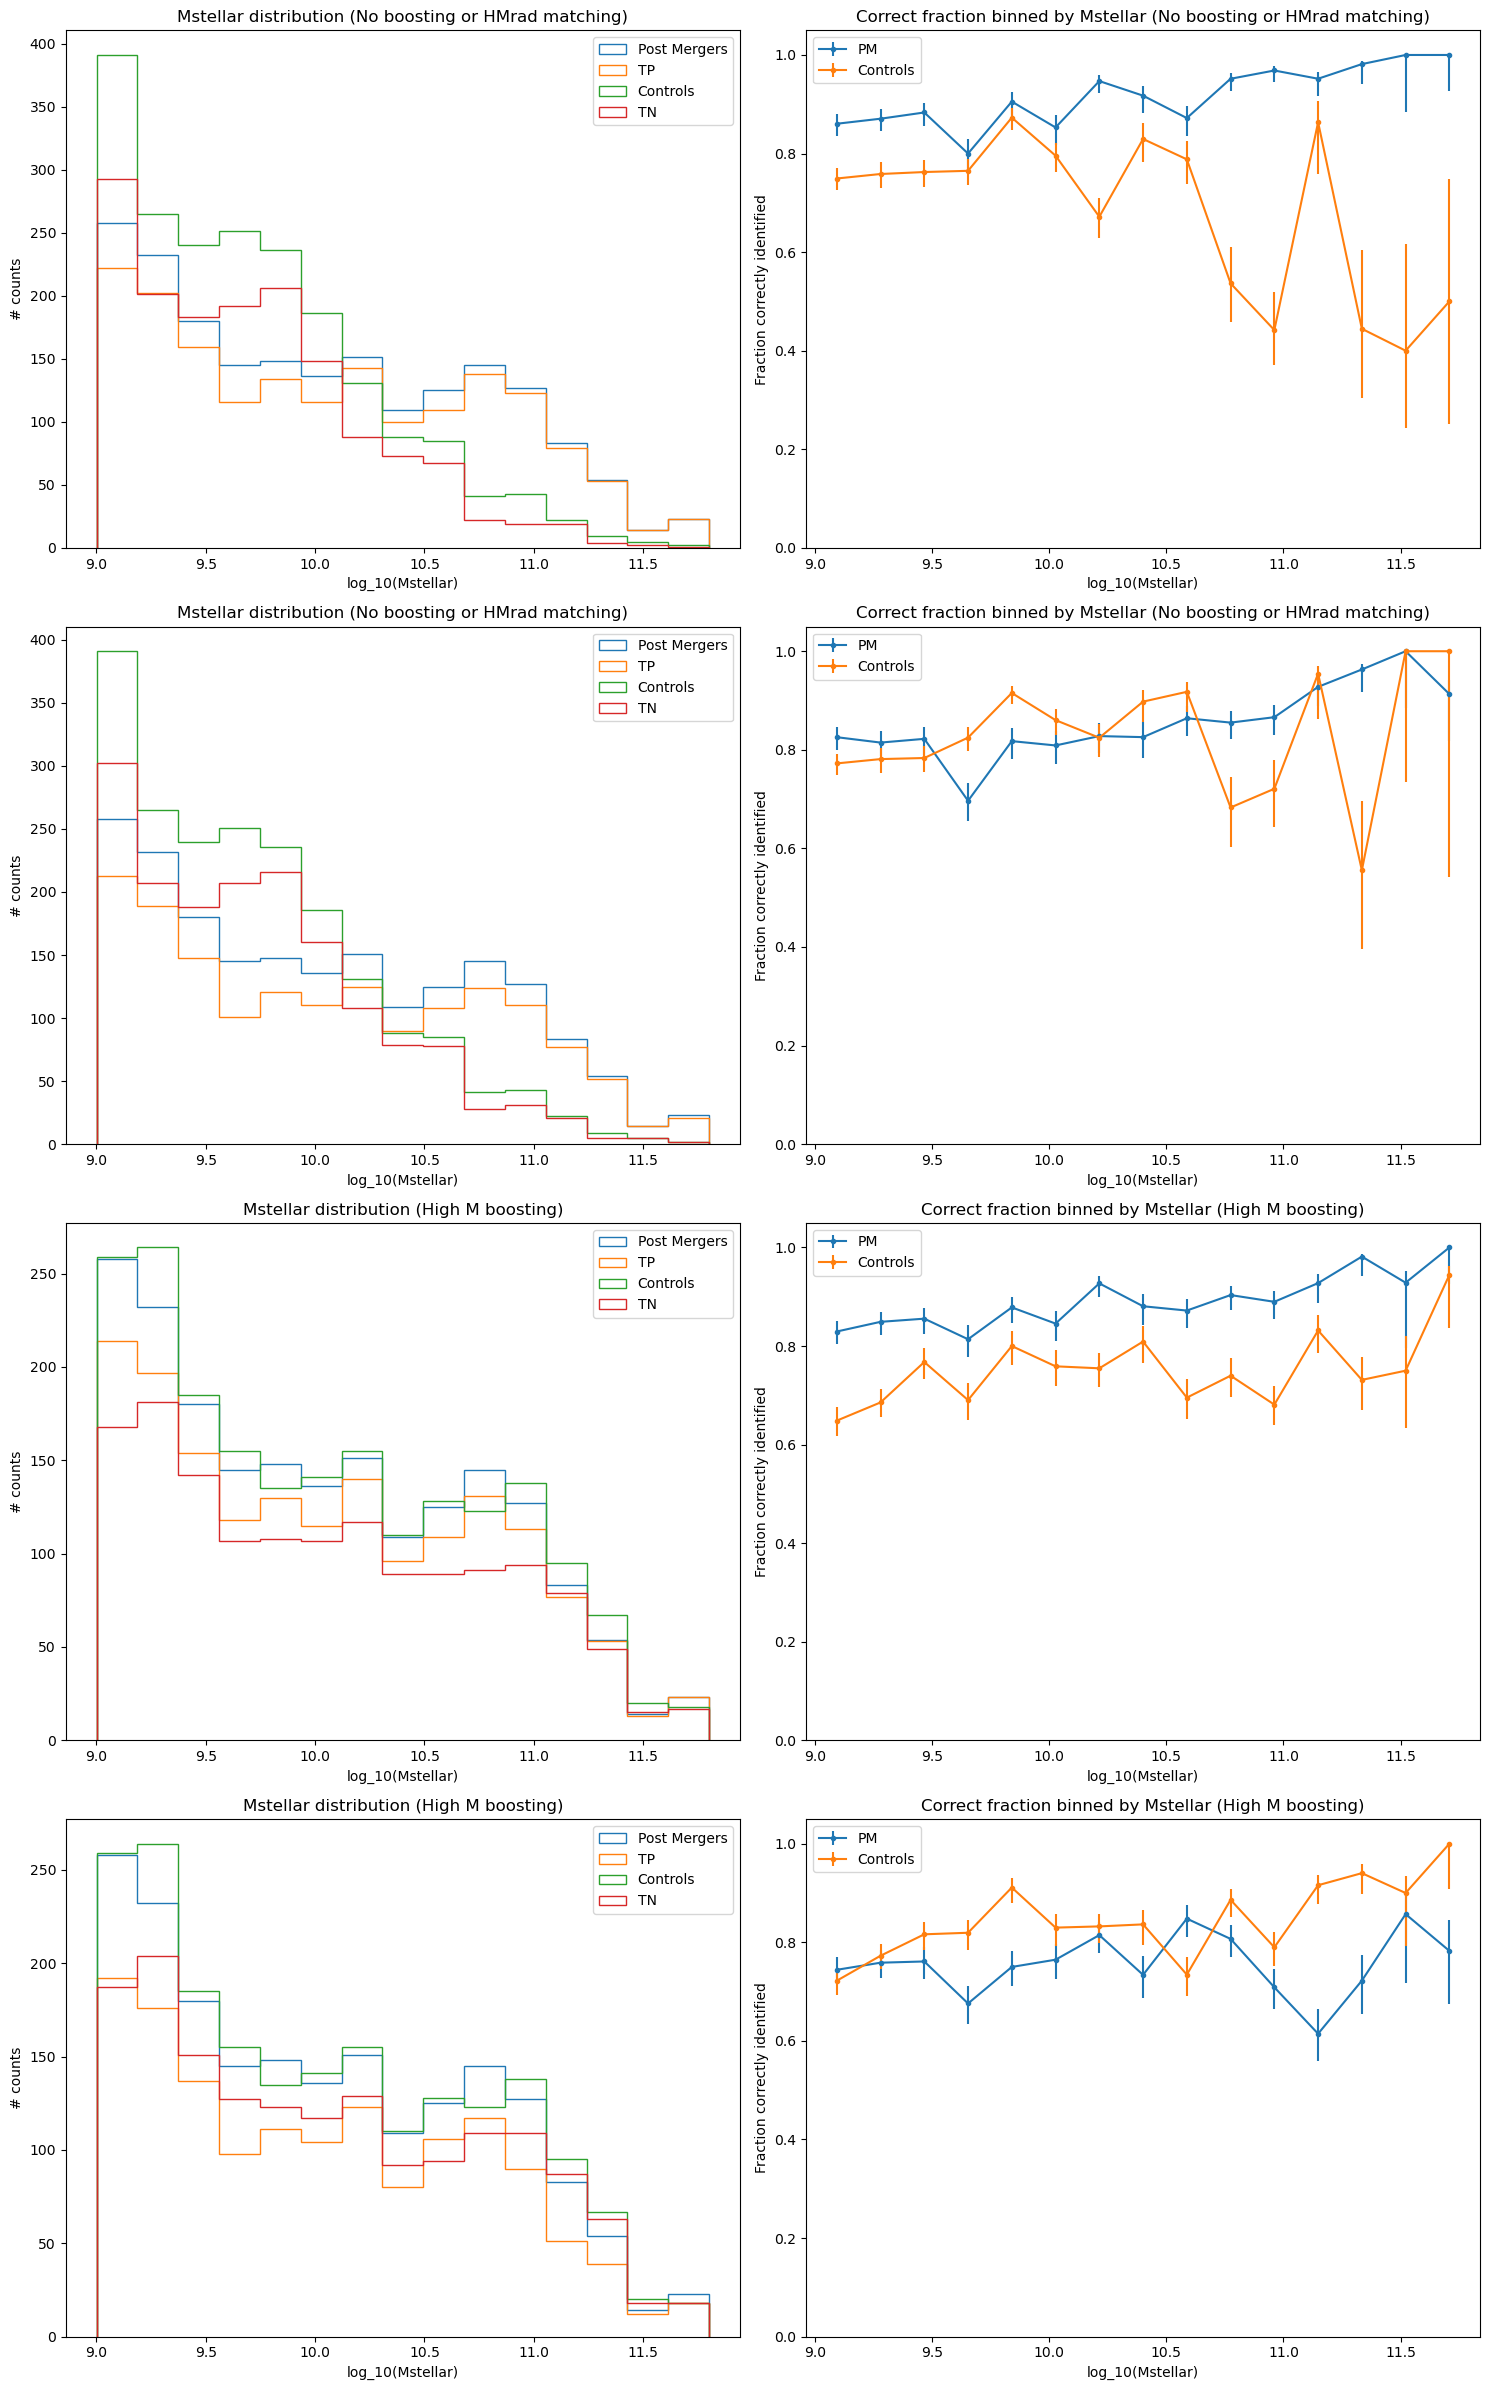

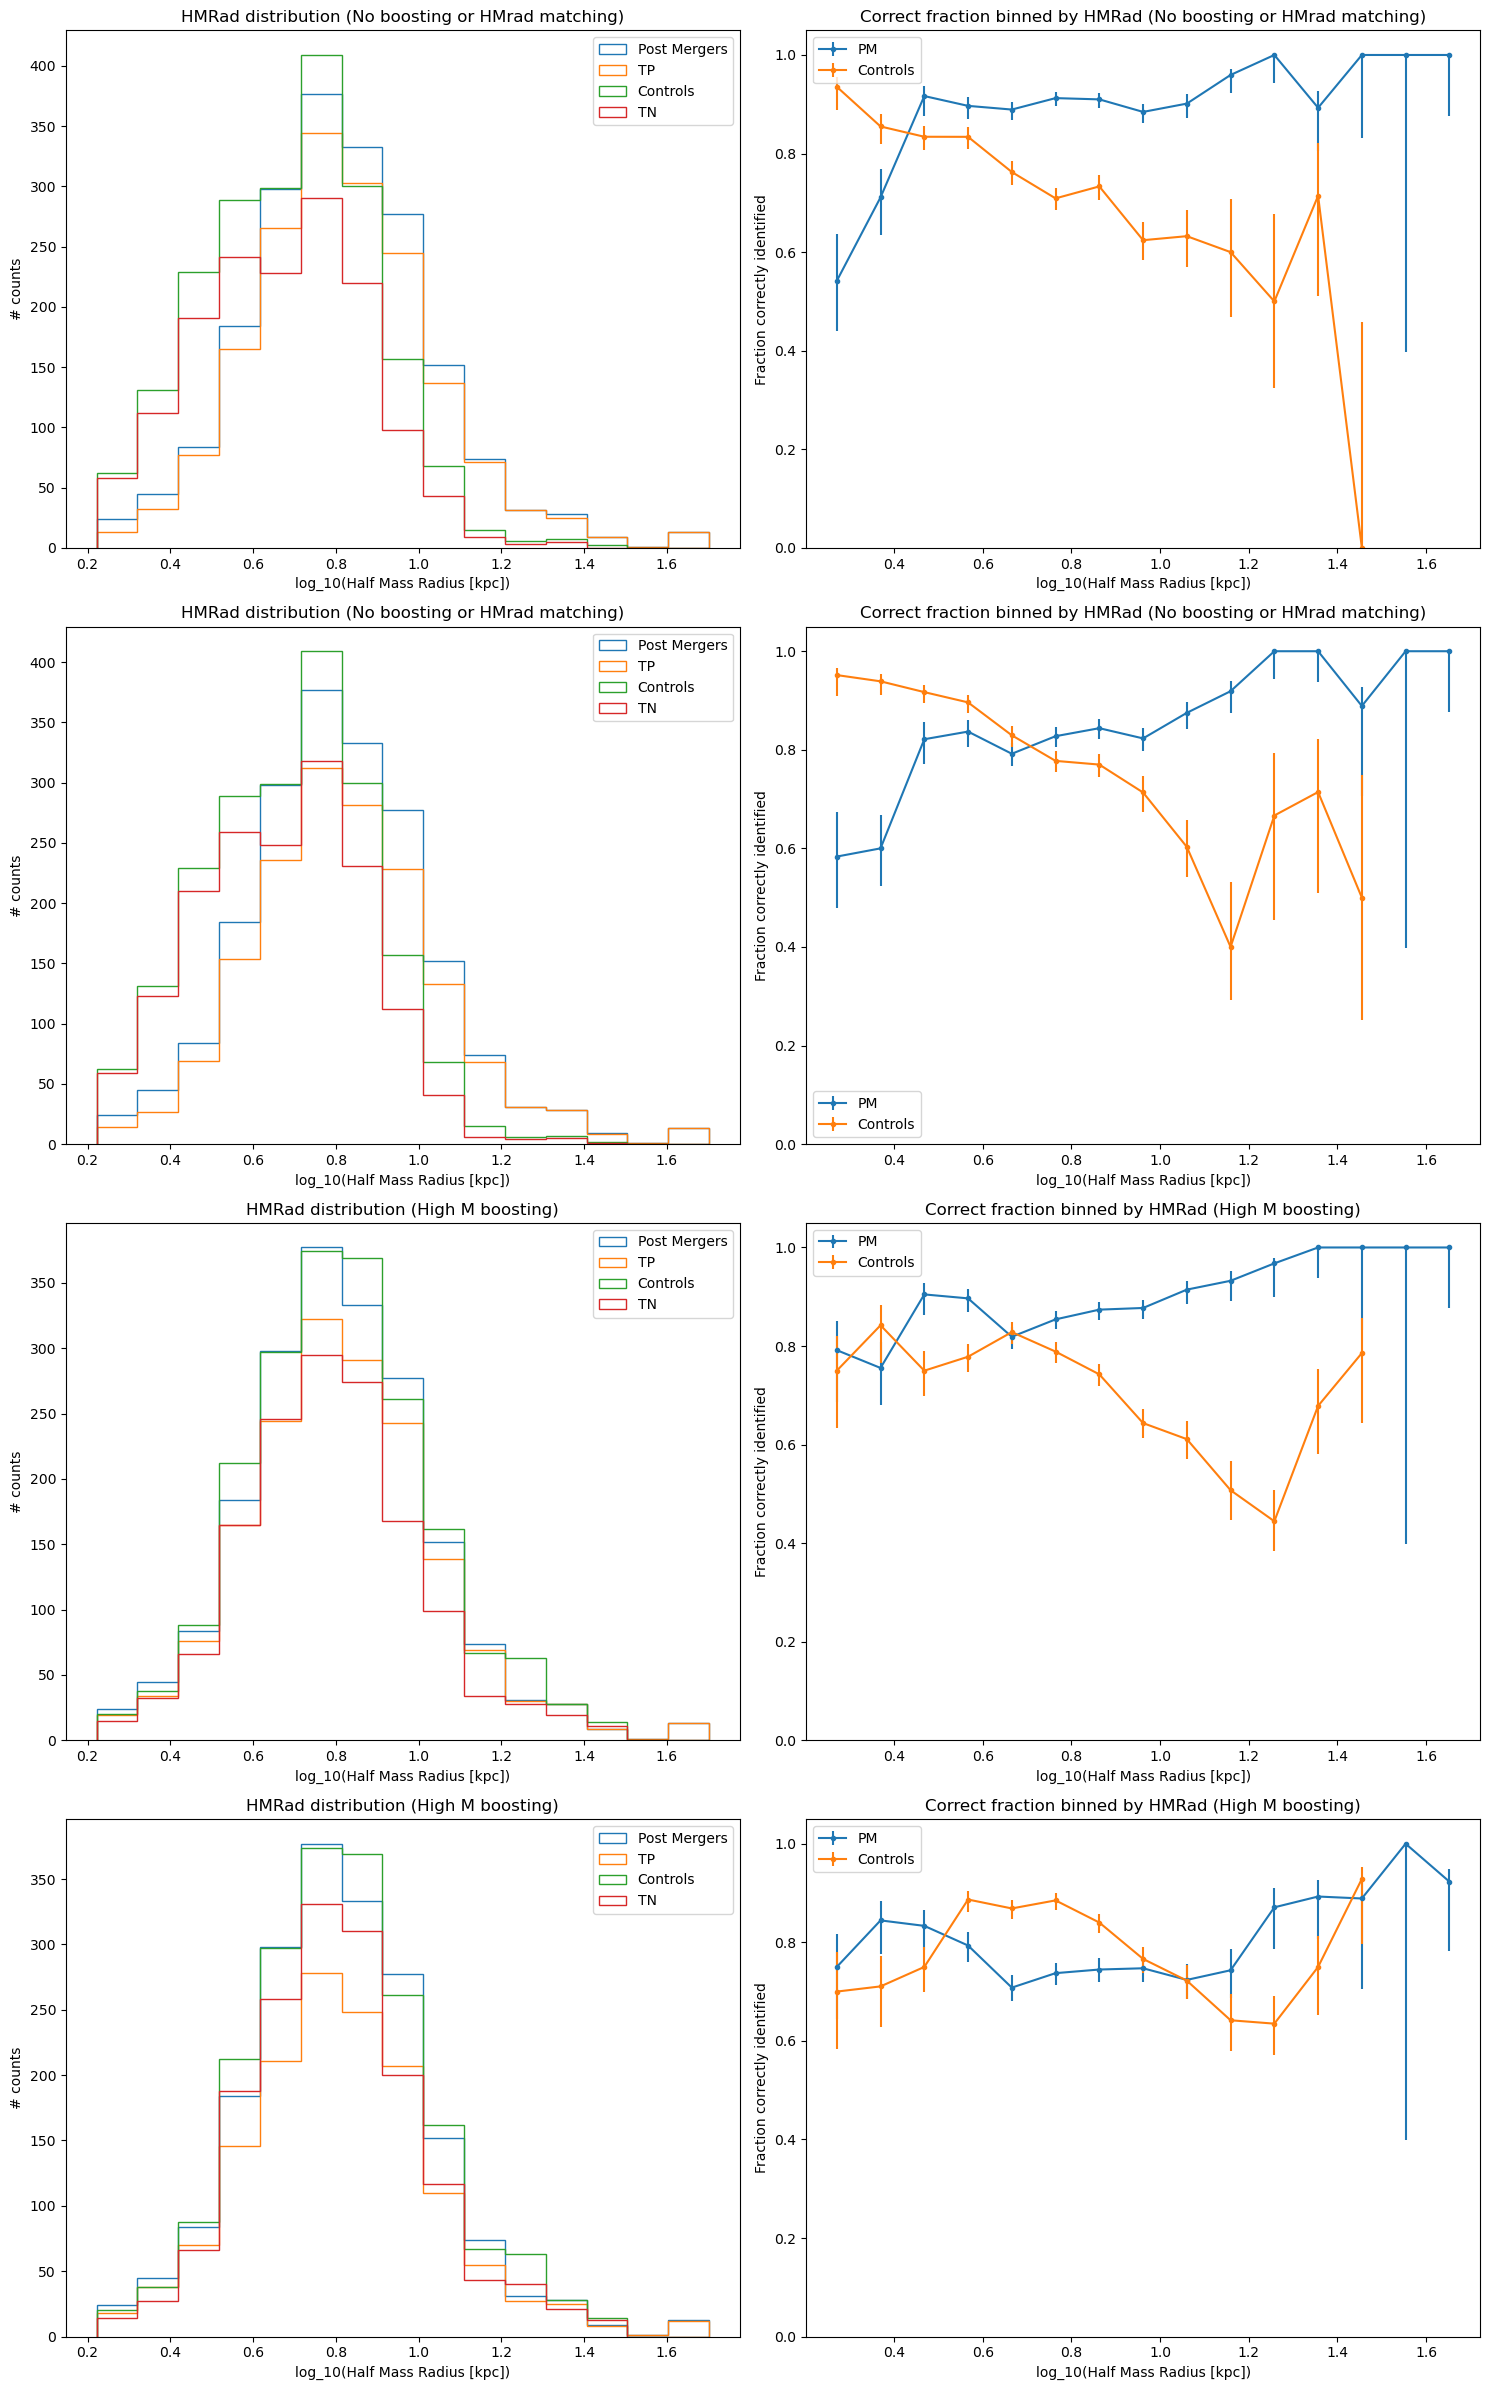

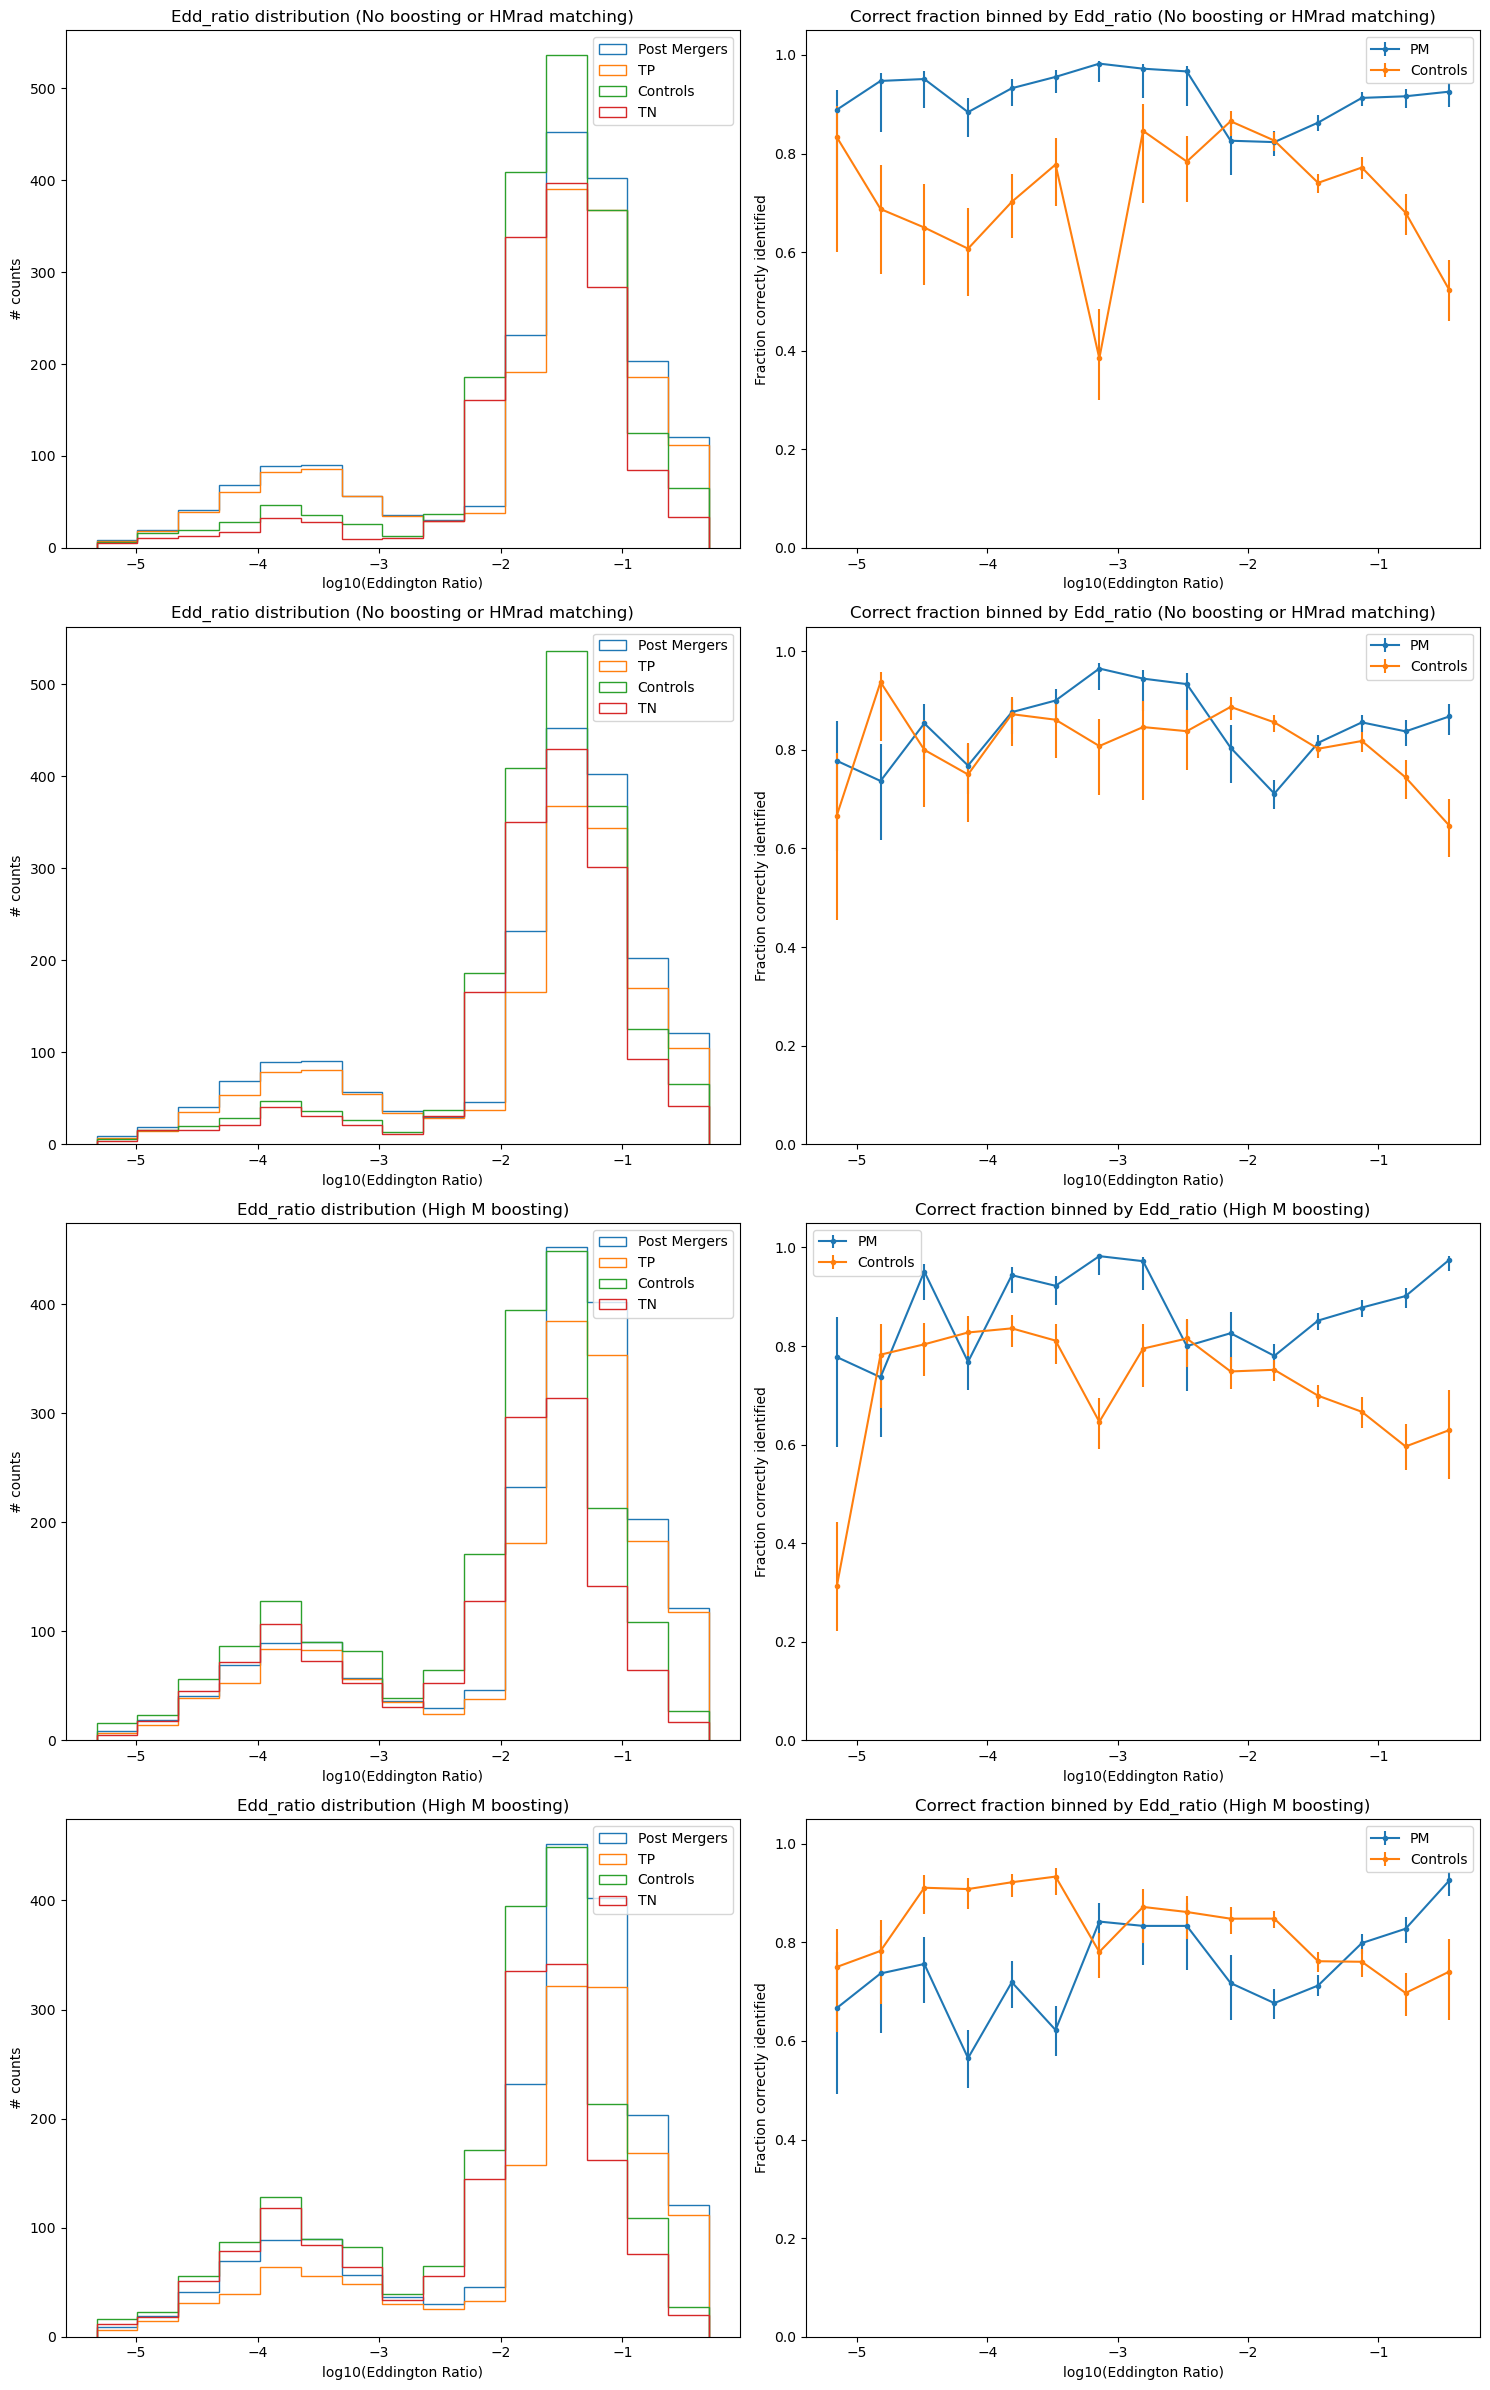

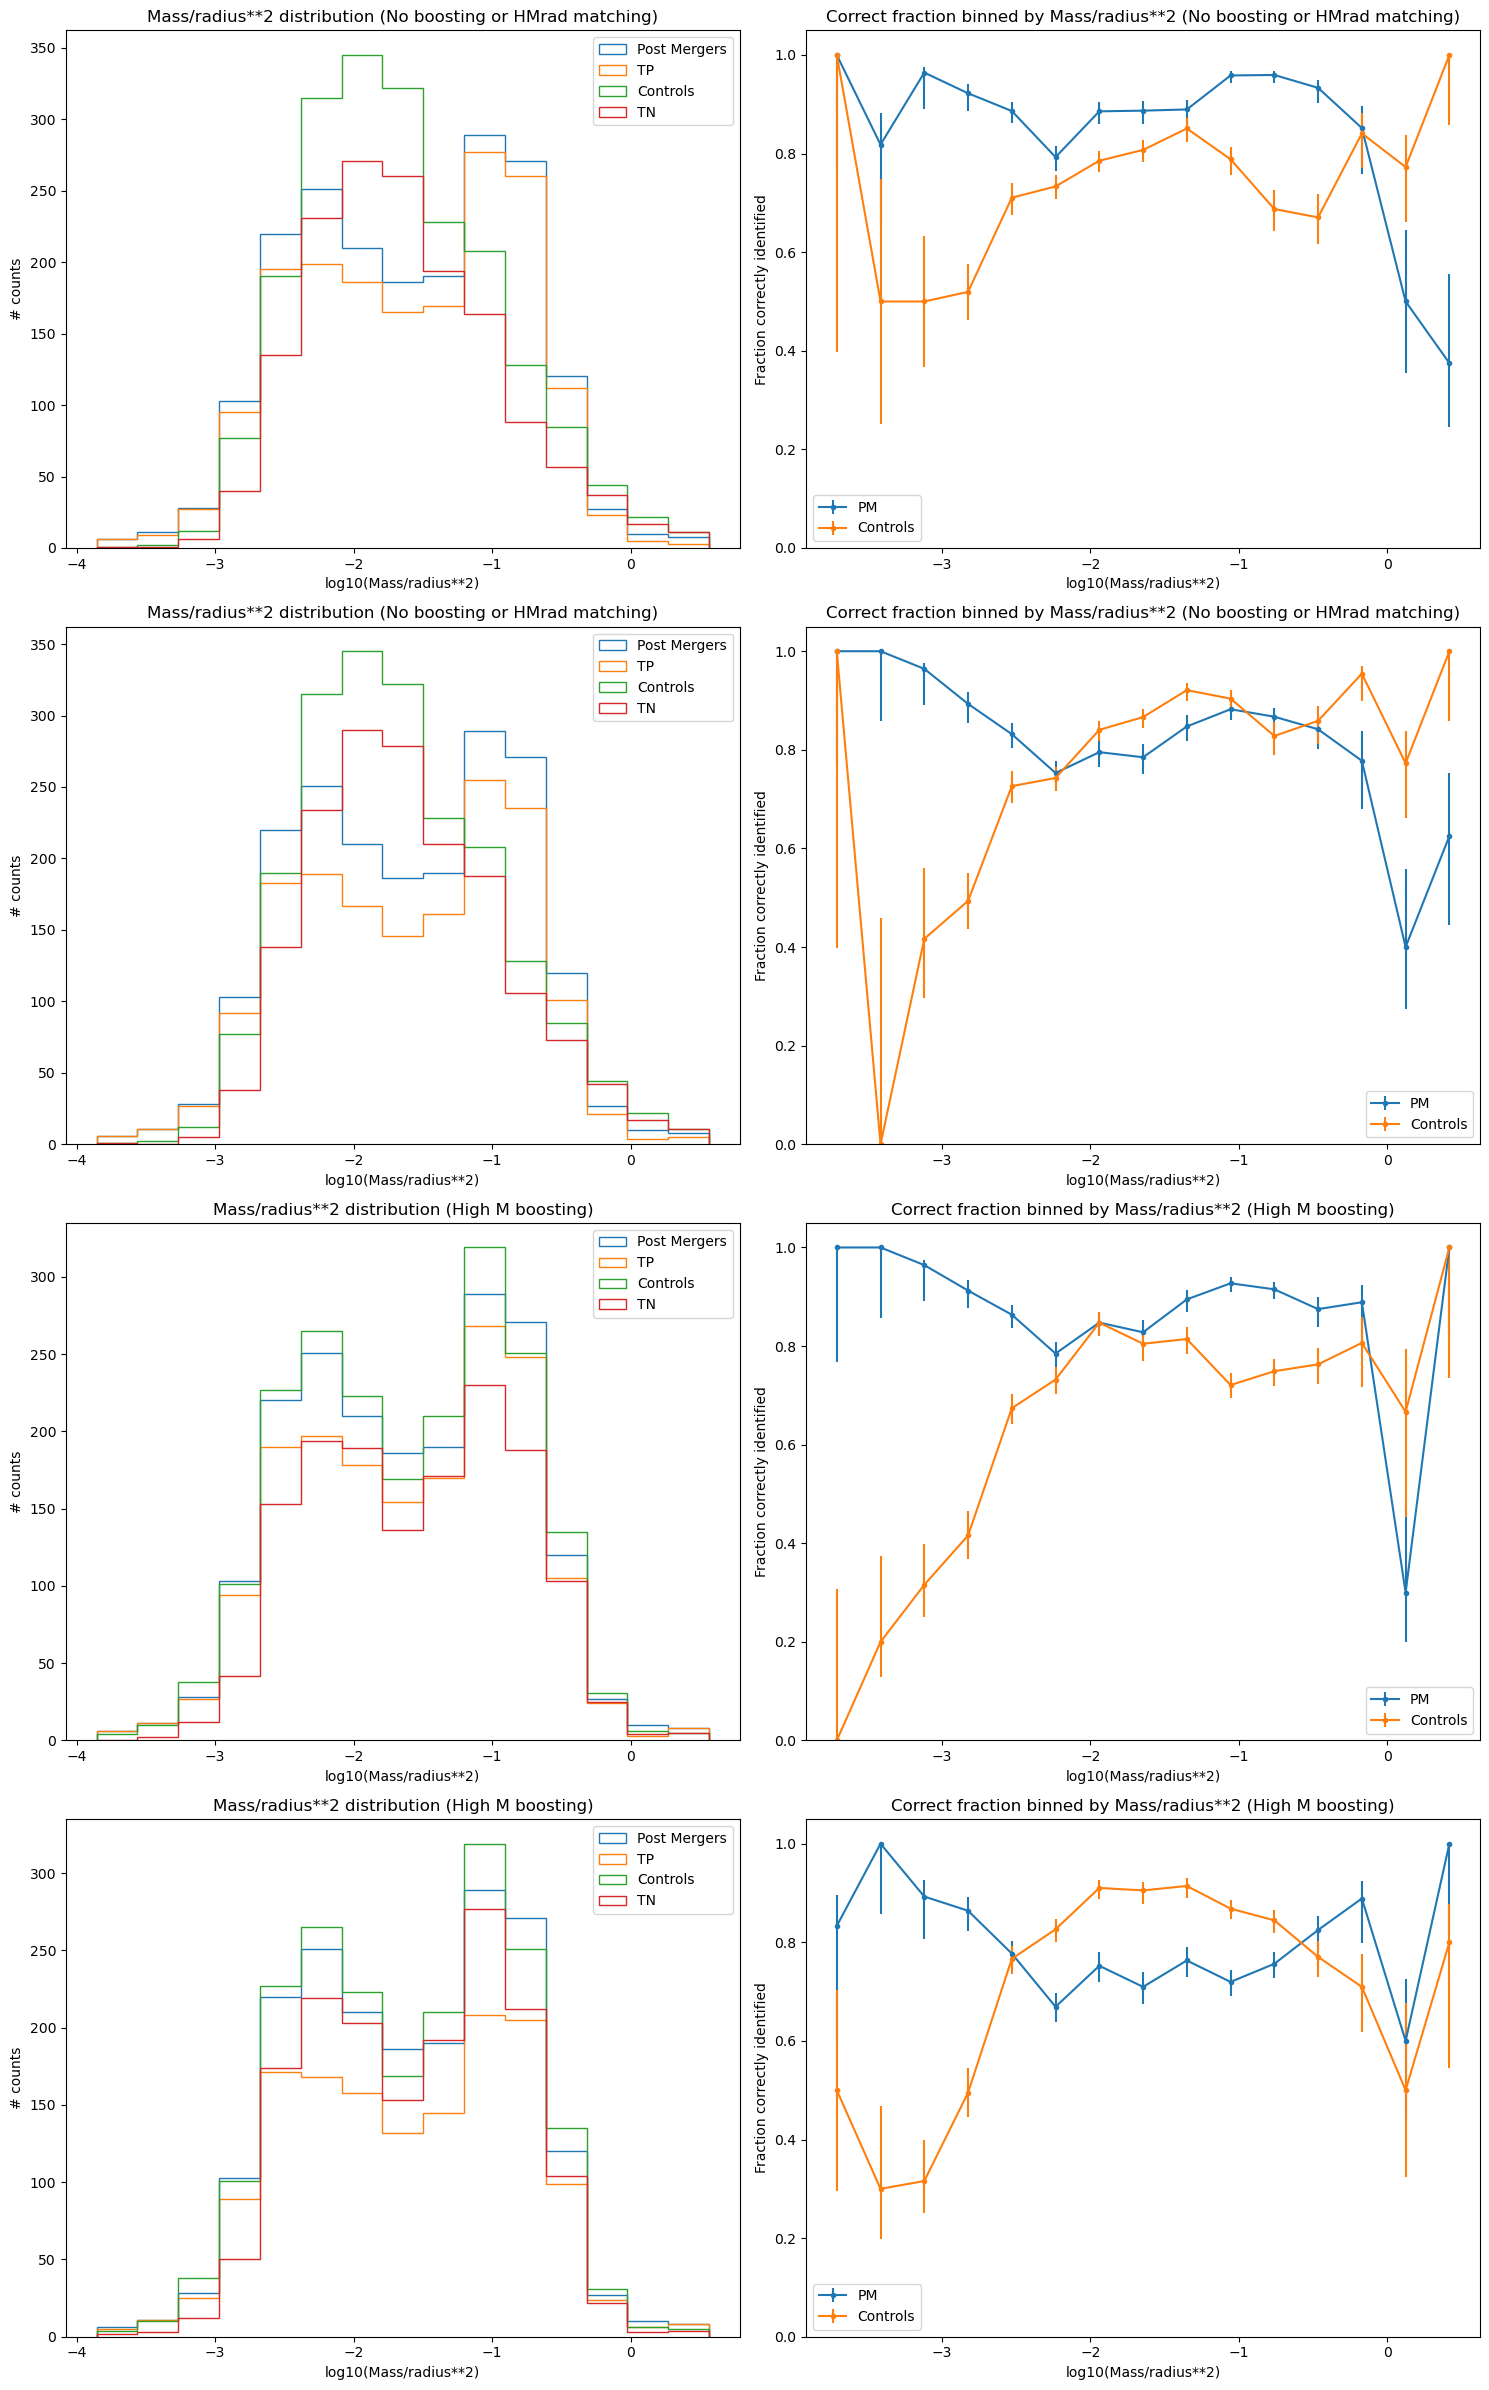

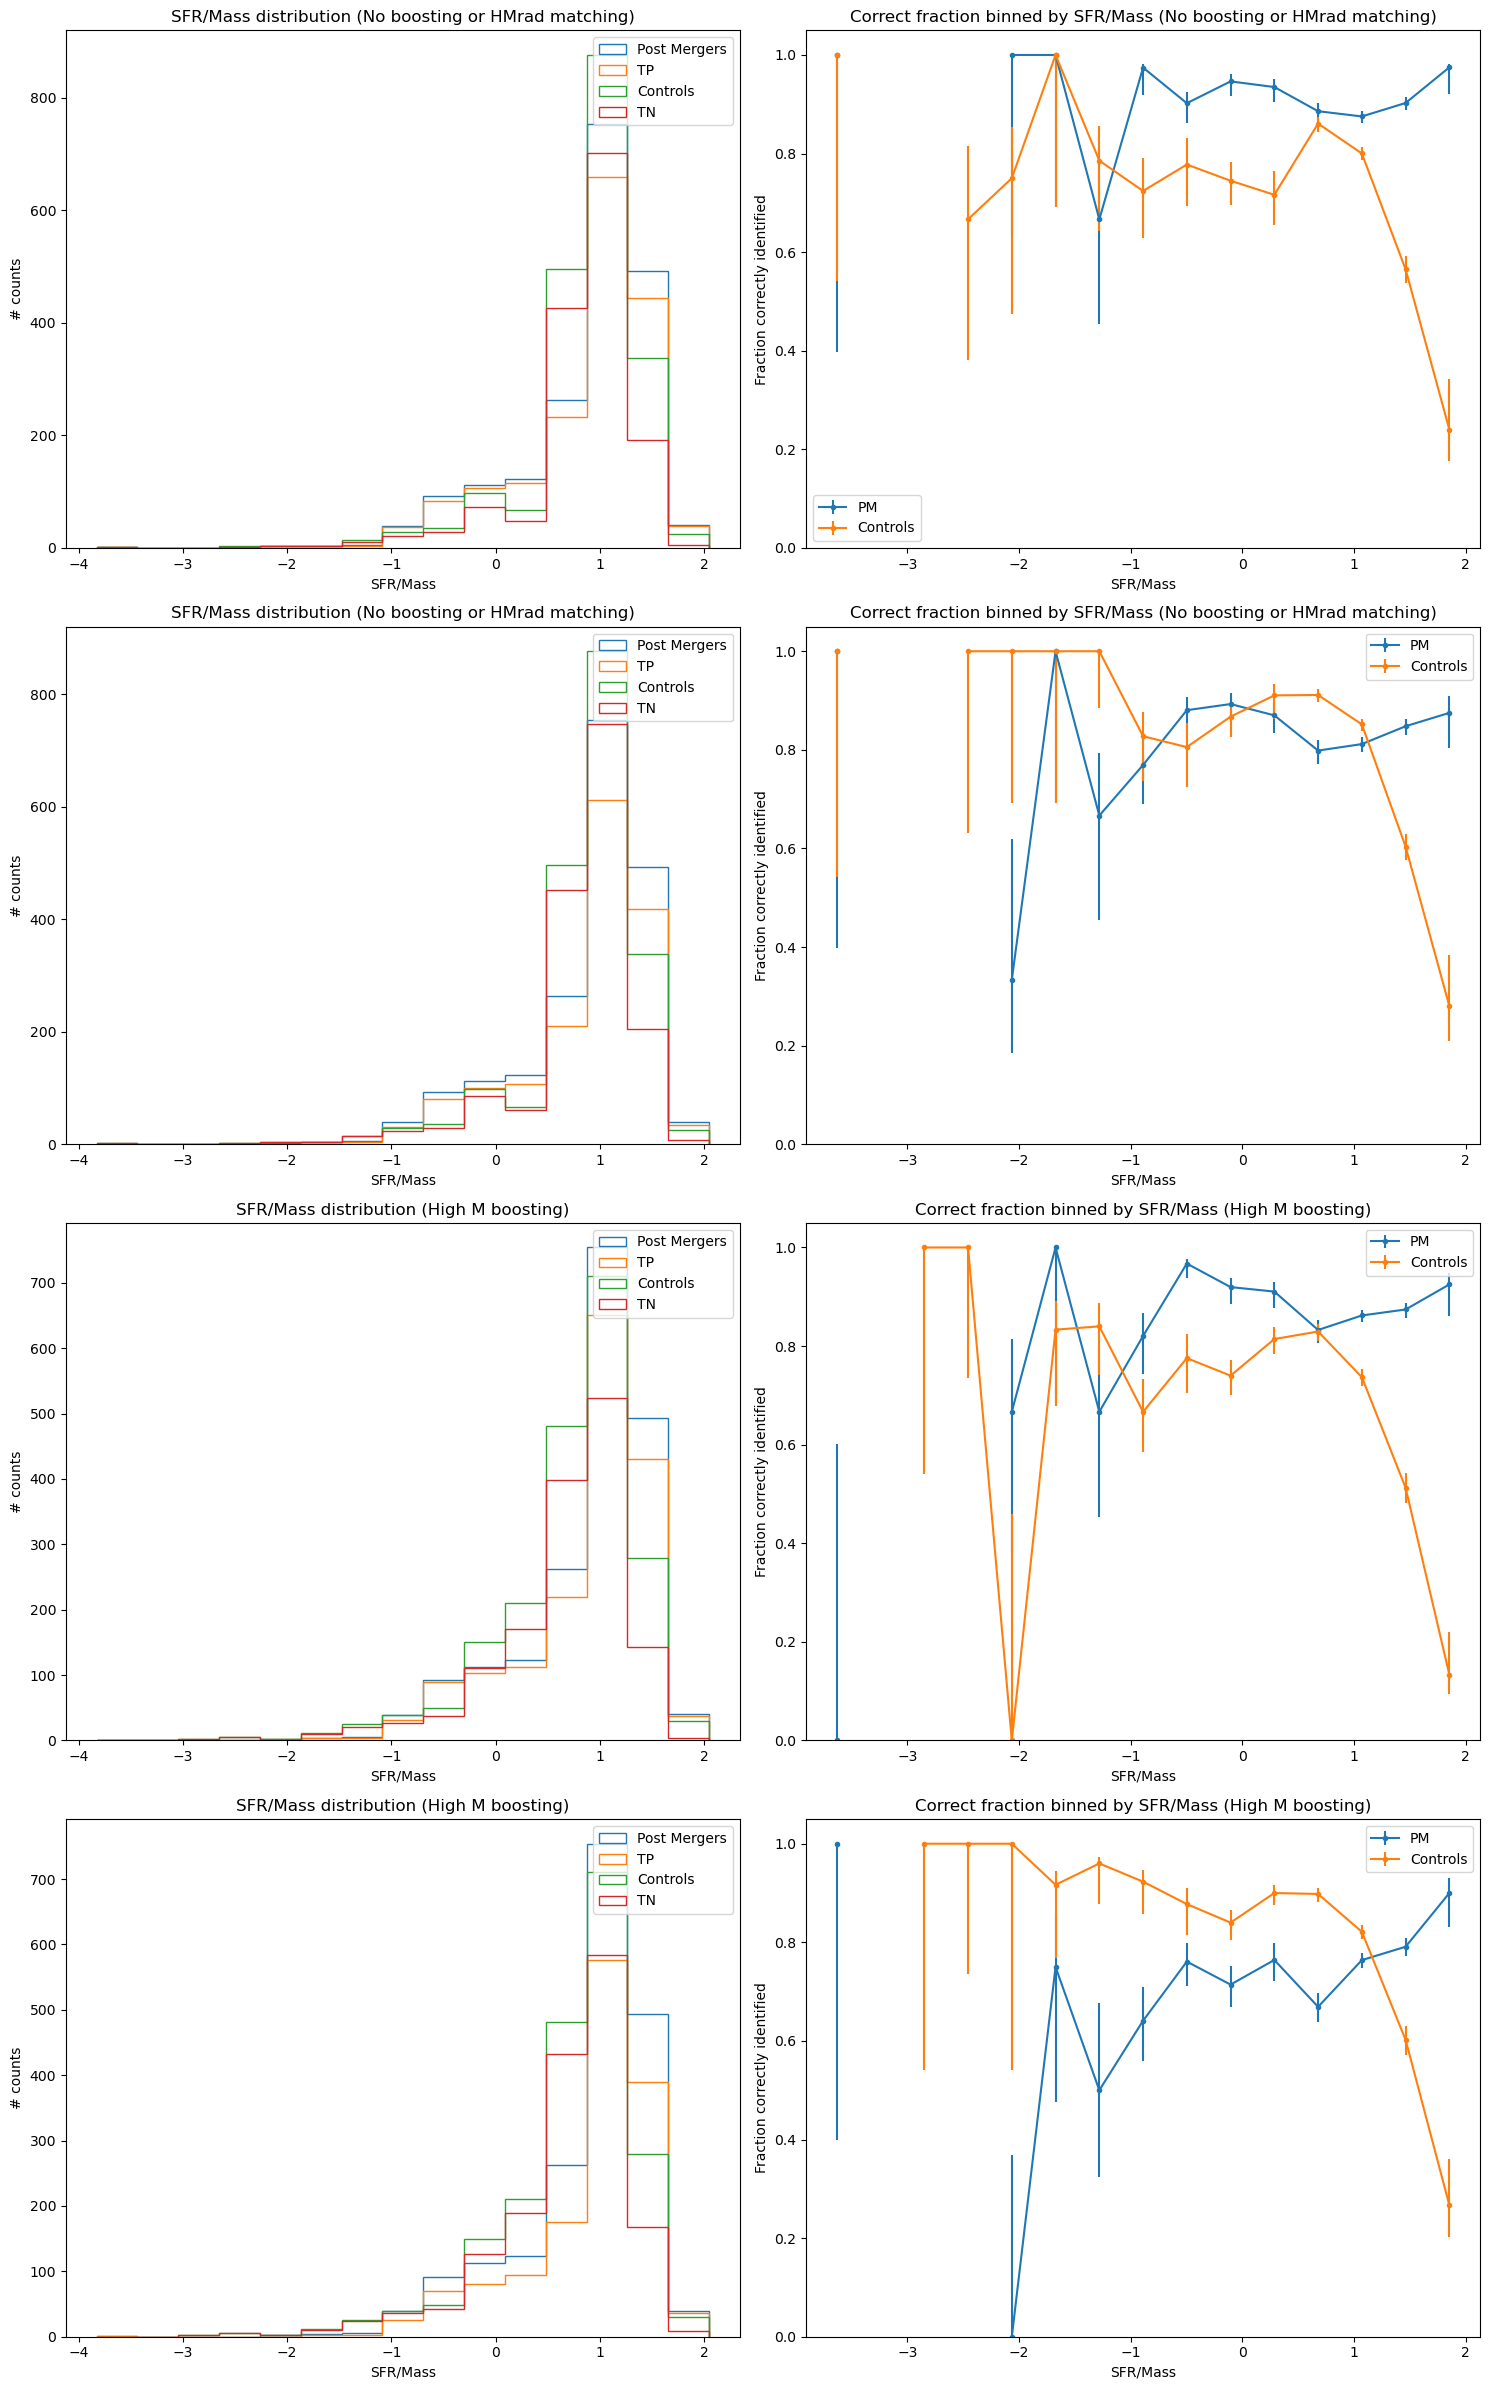

In [5]:
plot_multi_results(results_list.values(), params, no_log)

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(run_info)

    RUN_ID  N_EPOCHS  PIX_SCALE    TH_OPT  TH_OPT_F1   TRA_ACC   VAL_ACC  \
65     111        50         50  0.540541   0.385385  0.778143  0.748117   
69     115        50         50  0.287287   0.143143  0.808599  0.803006   
73     117        50         50  0.498498   0.371371  0.797521  0.781494   

    TRA_LOSS  VAL_LOSS  TEST_SIZE_TRN  TEST_SIZE_VAL  N_PICTURES  \
65  0.461419  0.488800            0.3            0.5       42846   
69  0.407806  0.412303            0.3            0.5       42846   
73  0.428781  0.446625            0.3            0.5       42846   

    learing_rate  patience  batch_size  ratio_merger  dt_merger  \
65         0.001        10          32           0.1        0.2   
69         0.001        10          32           0.1        0.2   
73         0.001        10          32           0.1        0.2   

    ratio_nonmerger  dt_nonmerger  snap_lower  snap_upper  \
65              0.1           1.0          28          50   
69              0.1           1

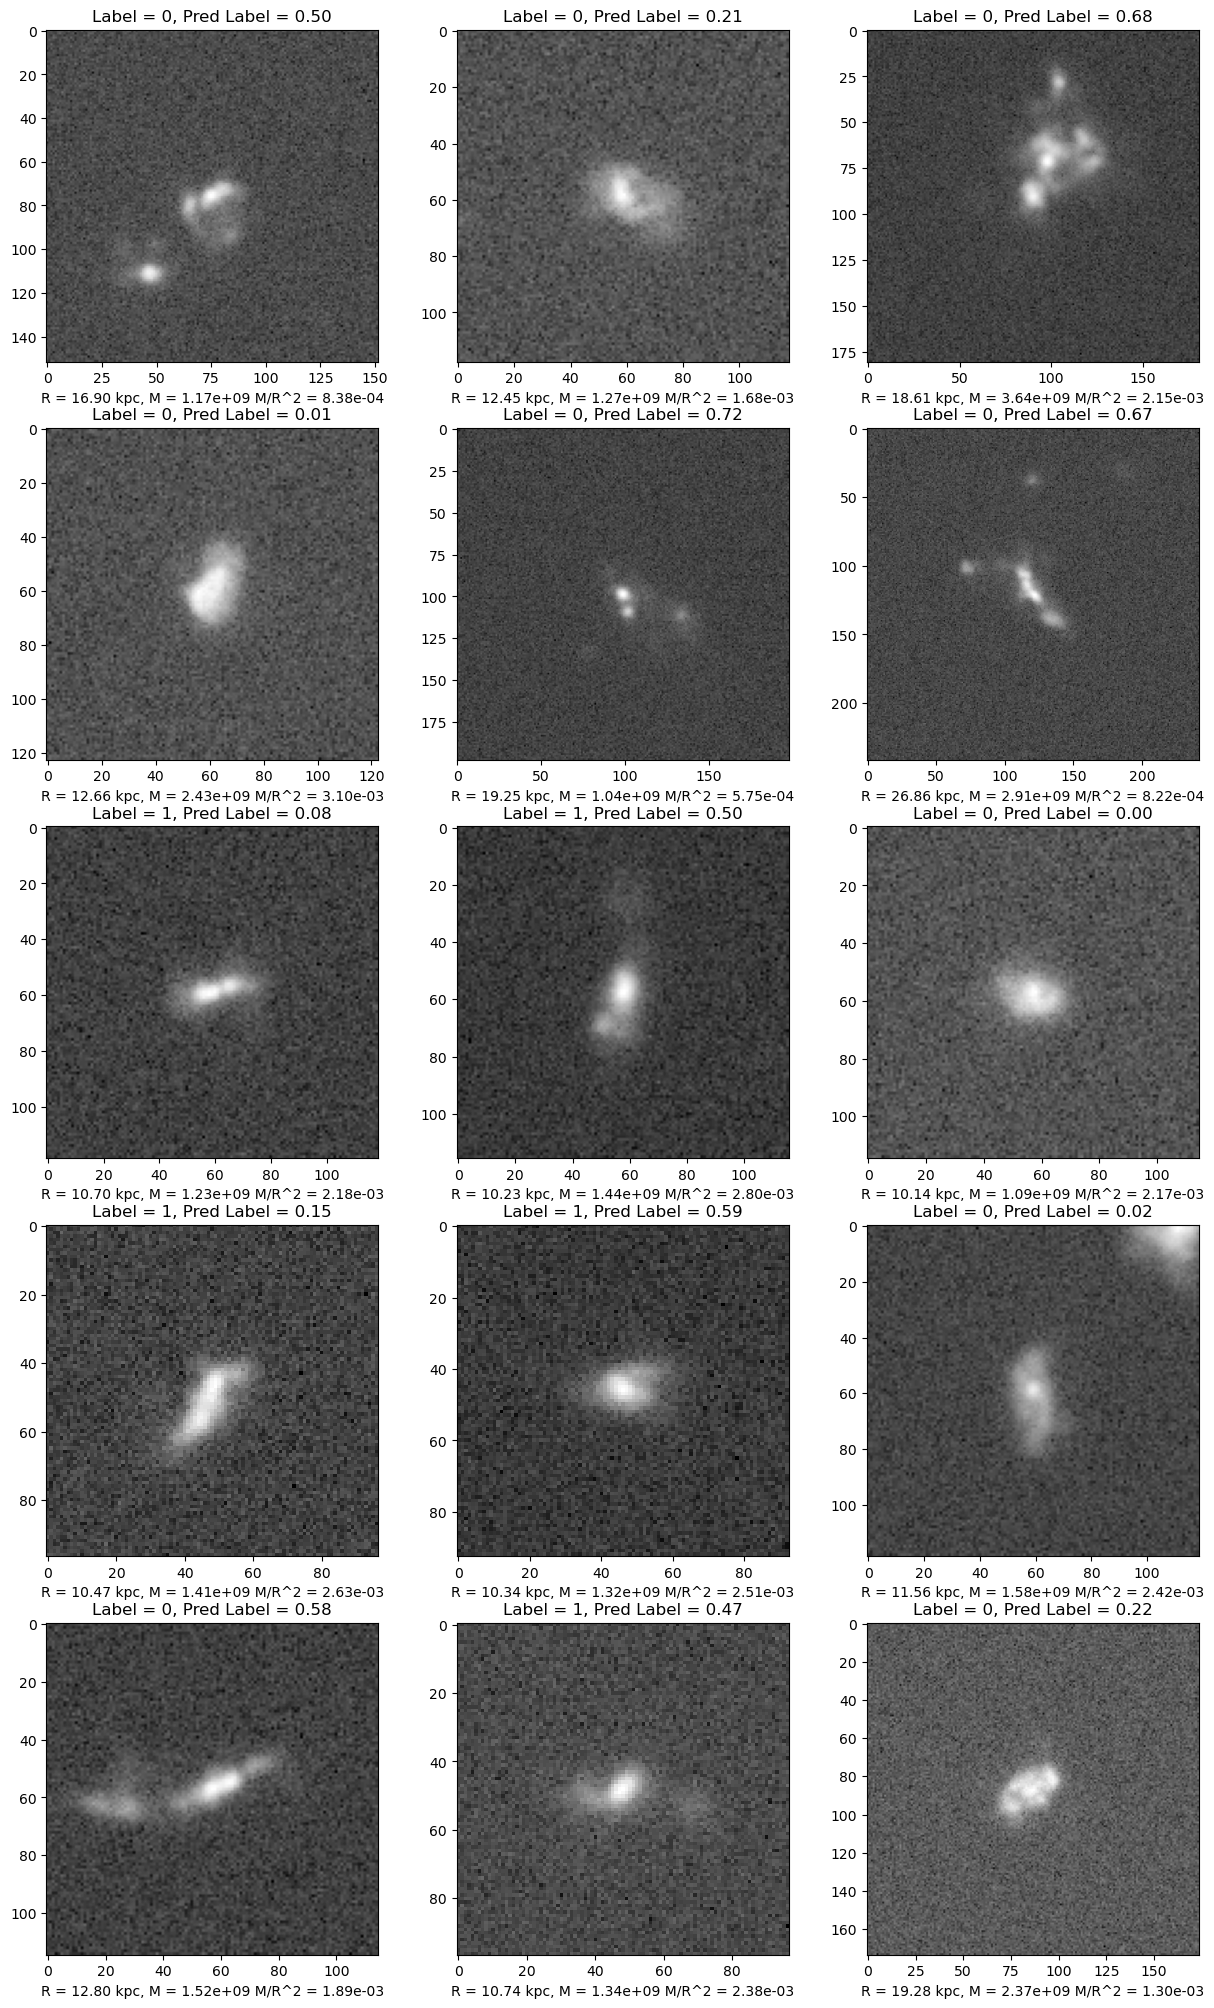

In [22]:
# Plot a few example galaxies from each population

#dfs = [TP, FP, TN, FN]
dfs = results_list.values()

mass_lims_list = [[5, 10], [20, 25], [25, 45], [45, 75]]
hm_rad_lims = [[6.3, 10], [10, 16], [16, 25]]
mass_rad_lims = [[1e-4, 10**-2.5], [1e-4, 10**-2.5], [1e-4, 10**-2.5], [1e-4, 10**-2.5], [1e-4, 10**-2.5]]

fig = plt.figure(figsize = (15,5 * len(mass_rad_lims)))
ax = fig.subplots(len(mass_rad_lims),len(dfs))

for j, mass_rad_lim in enumerate(mass_rad_lims):

    for i, df in enumerate(dfs):
        df_filt = df.loc[(df['Mass/radius**2'] > mass_rad_lim[0]) & (df['Mass/radius**2'] < mass_rad_lim[1])].reset_index(drop = True)
        if (len(df_filt) > 0):
            idx = np.random.randint(0, len(df_filt))
            hdul = fits.open(real_dir + 'SFID_%07d_SNAP_%02d.fits' %(df_filt['SFID'][idx], df_filt['SnapNum'][idx]))
            ax[j,i].imshow(hdul[1].data[0], cmap = 'gray_r')
            ax[j,i].set_title('Label = %01d, Pred Label = %.02f' %(df_filt['LABEL'][idx], df_filt['PRED_LABEL'][idx]))
            ax[j,i].set_xlabel('R = %.2f'%(df_filt['HMRad'][idx] / 0.7) + ' kpc, M = %.2e'%(df_filt['Mstellar'][idx] * 1e10) + ' M/R^2 = %.2e' %(df_filt['Mass/radius**2'][idx]))

In [58]:
params = ['Edd_ratio']

no_log = ['Redshift', 'ratio_recent', 'Z', 'ratio_recent', 'dt_recent', 'ratio_biggest', 'dt_biggest','GAS_FRAC']

scale = {'Mstellar': 1e10, 'MDM': 1e10, 'Mgas': 1e10, 'HMRad': 1, 'MBH': 1e10, 'BHacc' : 1e10, 'SFR' : 1, 'HMRad' : 1, 'edd_ratio' : 1, 'Edd_ratio' : 1, 'Mass/radius**2' : 1}
xlabels = {'Mstellar' : 'log_10(Mstellar)', 'Redshift' : 'Redshift', 'HMRad' : 'log_10(Half Mass Radius [kpc])', 'edd_ratio':'log10(Eddington Ratio)', 'Edd_ratio':'log10(Eddington Ratio)', 'Mass/radius**2' : 'log10(Mass/radius**2)'}
title_labels = {0: '(No boosting or HMrad matching)', 1: '(No boosting or HMrad matching)' , 2: '(High M boosting)', 3: '(High M boosting)', 4: '(Boosting and HMrad matching)', 5: '(Boosting and HMrad matching)', 6: '(Boosting and HMrad matching)'}

def plot_edd_ratio(results_list, params, no_log):
    
    for param in params:
        
        fig = plt.figure(figsize = (22,6 * len(results_list)))
        ax = fig.subplots(len(results_list),3)
        
        probs = []
        
        for i, results in enumerate(results_list):
            
            if param == 'Edd_ratio':
                results = results.loc[results['Edd_ratio'] > 1e-6]
            
            error_bars = []

            if param in no_log:
                counts_M_total, edges_M, bars = ax[i,0].hist(results.loc[results['LABEL'] == 1][param].values, bins = 15, histtype = 'step', label = 'Post Mergers')
                counts_M, edges, bars = ax[i,0].hist(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)][param].values, bins = edges_M, histtype = 'step', label = 'TP')
                counts_NM_total, edges_NM, bars = ax[i,0].hist(results.loc[results['LABEL'] == 0][param].values, bins = edges_M, histtype = 'step', label = 'Controls')
                counts_NM, edges, bars = ax[i,0].hist(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][param].values, bins = edges_M, histtype = 'step', label = 'TN')

            else:

                results_M_total = np.log10(results.loc[results['LABEL'] == 1][param].values * scale[param])
                results_M = np.log10(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)][param].values * scale[param])
                results_NM_total = np.log10(results.loc[results['LABEL'] == 0][param].values * scale[param])
                results_NM = np.log10(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][param].values * scale[param])

                results_M_total[results_M_total == -np.inf] = 0
                results_M[results_M == -np.inf] = 0
                results_NM_total[results_NM_total == -np.inf] = 0
                results_NM[results_NM == -np.inf] = 0
                
                counts_M_total, edges_M, bars = ax[i,0].hist(results_M_total, bins = 30, histtype = 'step', label = 'Post Mergers')
                counts_M, edges, bars = ax[i,0].hist(results_M, bins = edges_M, histtype = 'step', label = 'TP')
                counts_NM_total, edges_NM, bars = ax[i,0].hist(results_NM_total, bins = edges_M, histtype = 'step', label = 'Controls')
                counts_NM, edges, bars = ax[i,0].hist(results_NM, bins = edges_M, histtype = 'step', label = 'TN')

            if param not in no_log:
                edges_M = 10**(edges_M-10)

            c = 0.683
            k_M, k_NM = counts_M, counts_NM
            n_M, n_NM = counts_M_total, counts_NM_total
            p_M_lower, p_NM_lower = dist.beta.ppf((1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf((1-c)/2.,k_NM+1,n_NM-k_NM+1)
            p_M_upper, p_NM_upper = dist.beta.ppf(1-(1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf(1-(1-c)/2.,k_NM+1,n_NM-k_NM+1)



            probs_M_total = []
            probs_M = []
            probs_NM_total = []
            probs_NM = []
            bin_edges = []

            for j in range(len(edges_M) - 1):
                probs_M_total.append(results.loc[(results['LABEL'] == 1) & (results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_M.append(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)].loc[(results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_NM_total.append(results.loc[(results['LABEL'] == 0) & (results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_NM.append(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)].loc[(results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                bin_edges.append(np.array([edges_M[j], edges_M[j + 1]]))

            
            
            ax[i,0].set_title(param + ' distribution' + ' %s'%(title_labels[i]))
            ax[i,0].set_ylabel('# counts')
            ax[i,0].set_xlabel(xlabels[param])
            ax[i,0].legend()
            
            probs.append([probs_M_total, probs_M, probs_NM_total, probs_NM, bin_edges])


            centers = 0.5*(edges[1:]+ edges[:-1])
            
            yerr_low = p_M_lower - counts_M/counts_M_total
            yerr_up = p_M_upper - counts_M/counts_M_total 
            yerr_low[yerr_low > 0] = 0
            yerr_up[yerr_up < 0] = 0
            
            yerr = np.absolute(np.array([yerr_low, yerr_up]))
            ax[i,1].errorbar(centers, counts_M/counts_M_total, yerr = yerr, fmt = '.-', label = 'PM')

            yerr_low = p_NM_lower - counts_NM/counts_NM_total
            yerr_up = p_NM_upper - counts_NM/counts_NM_total 
            yerr_low[yerr_low > 0] = 0
            yerr_up[yerr_up < 0] = 0
            yerr = np.absolute(np.array([yerr_low, yerr_up]))

            ax[i,1].errorbar(centers, counts_NM/counts_NM_total, yerr = yerr , fmt = '.-', label = 'Controls')
            
            ax[i,1].set_ylabel('Fraction correctly identified')
            ax[i,1].set_title('Correct fraction binned by ' + param + ' %s'%(title_labels[i]))
            ax[i,1].set_ylim(0, 1.05)
            ax[i,1].set_xlabel(xlabels[param])
            ax[i,1].legend()
            
            ax[i,2].plot(centers, counts_M_total,'.-', label = 'PM')
            ax[i,2].plot(centers, counts_NM_total,'.-', label = 'Controls')
            ax[i,2].set_title('Test galaxies binned by Edd_ratio')
            ax[i,2].set_xlabel(xlabels[param])
            ax[i,2].set_ylabel('# counts')
            

        plt.tight_layout()

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


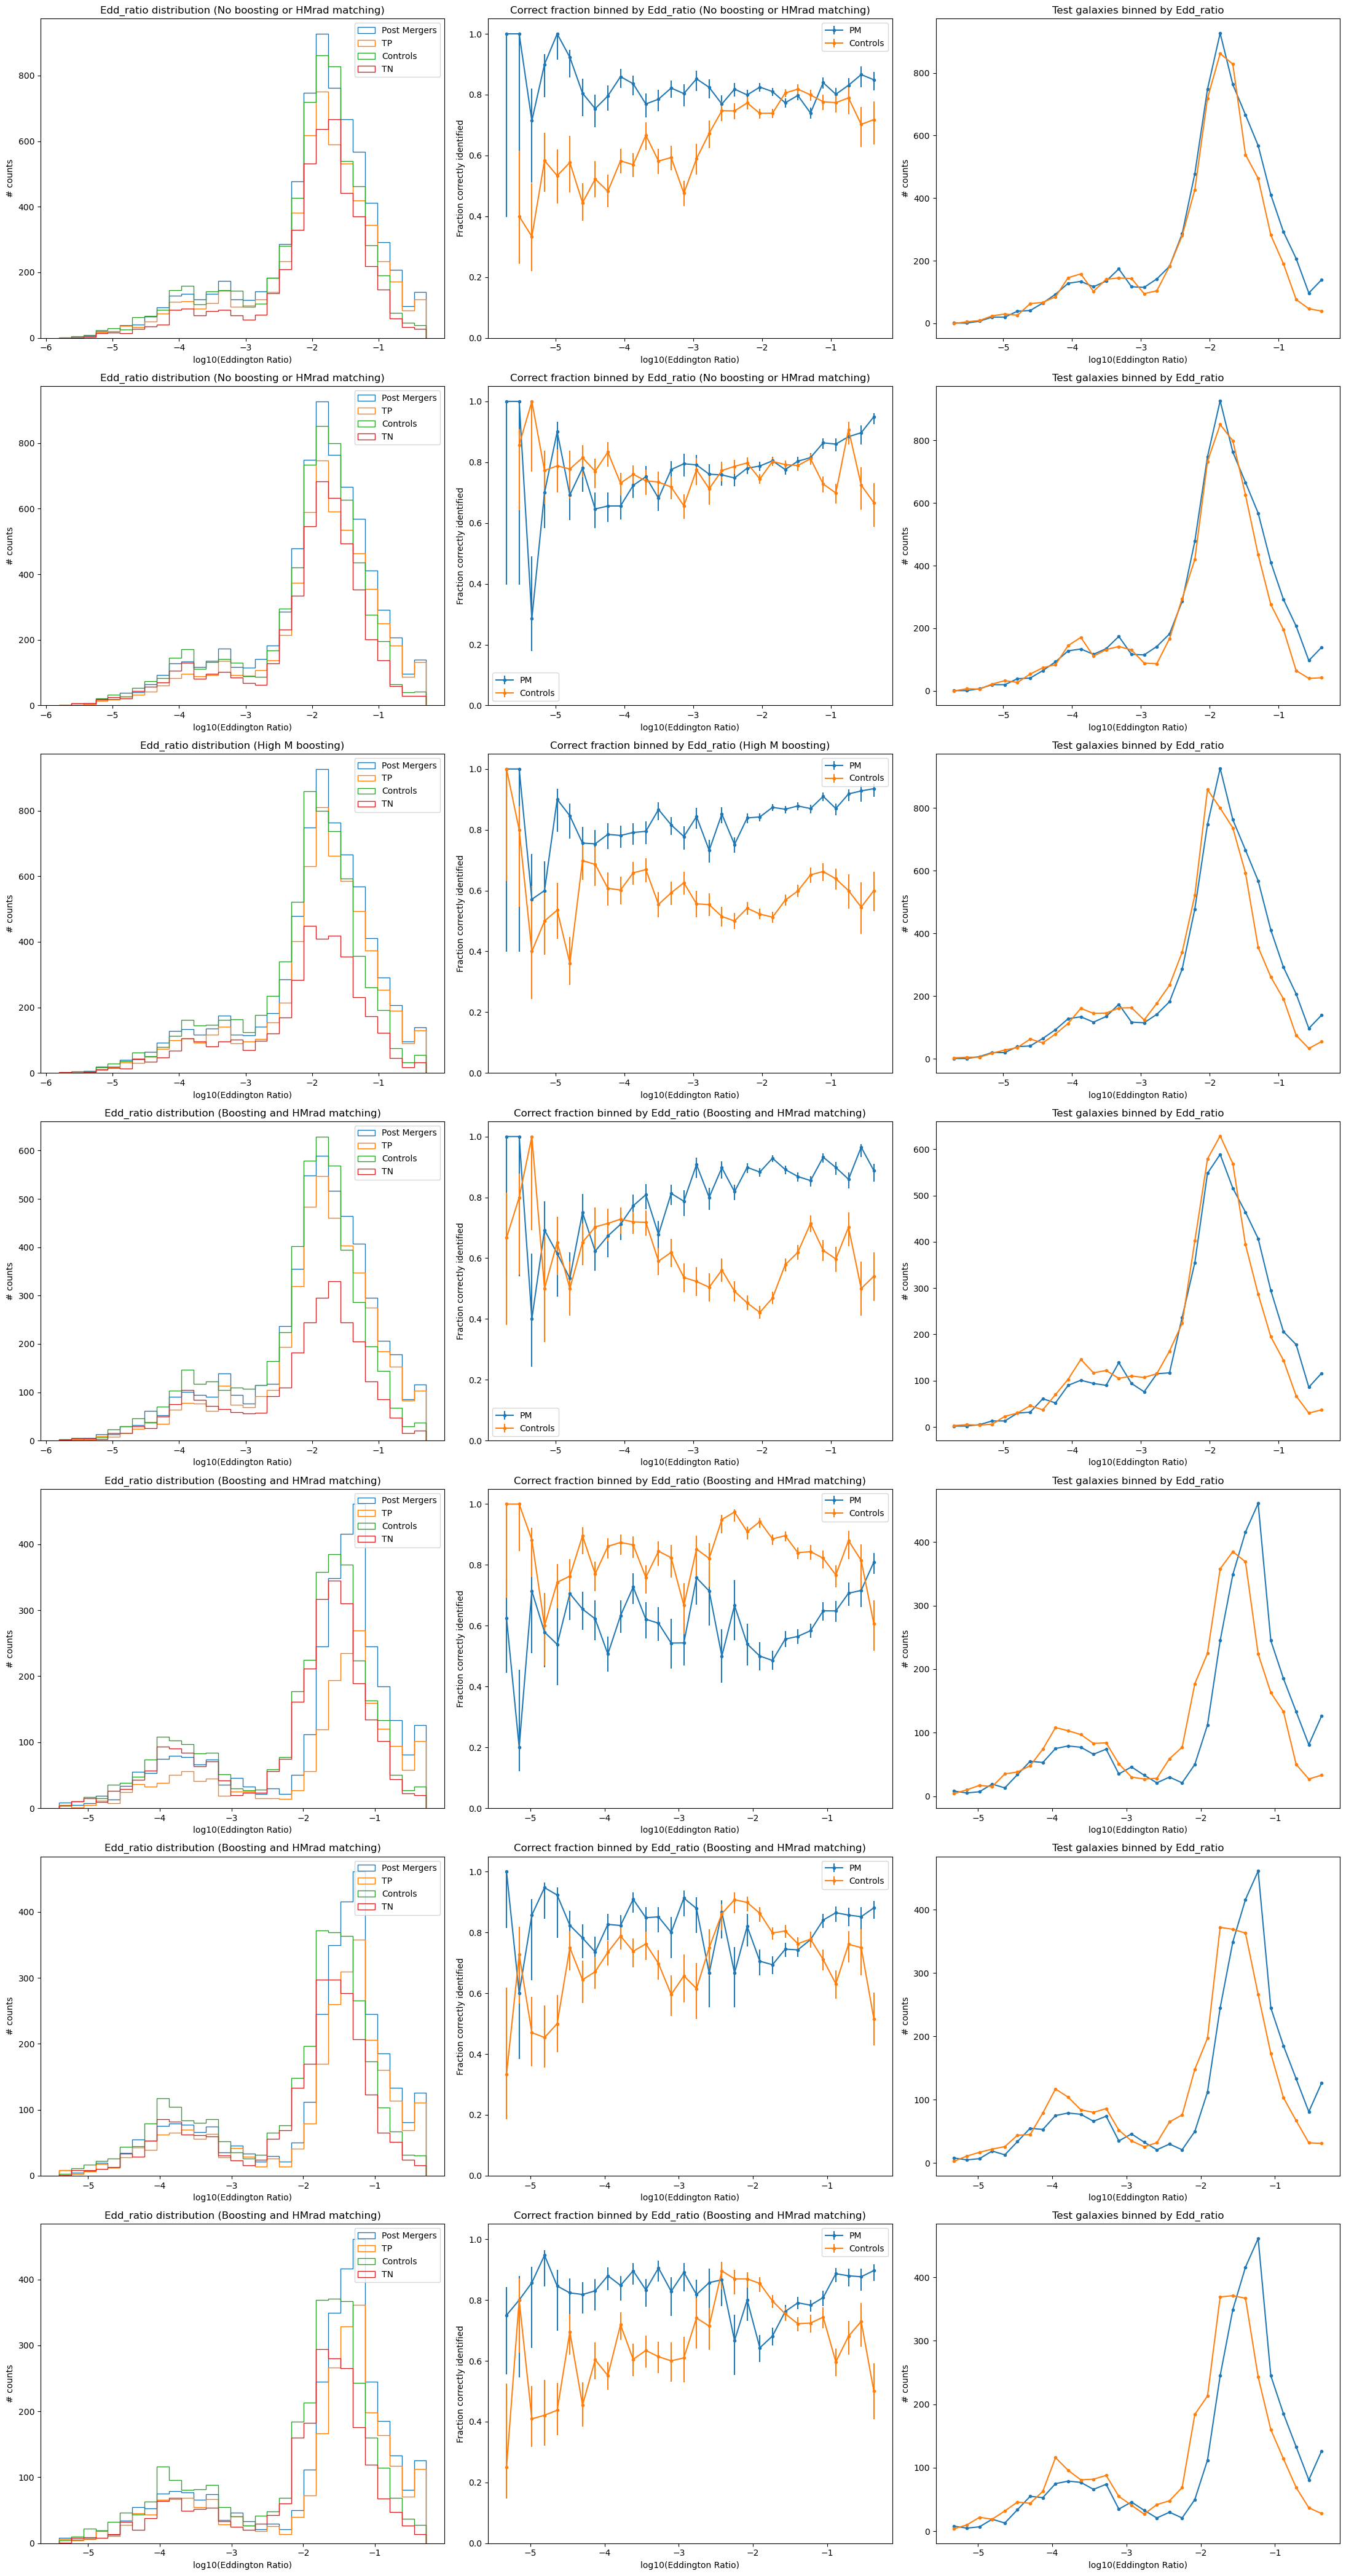

In [59]:
plot_edd_ratio(results_list.values(), params, no_log)

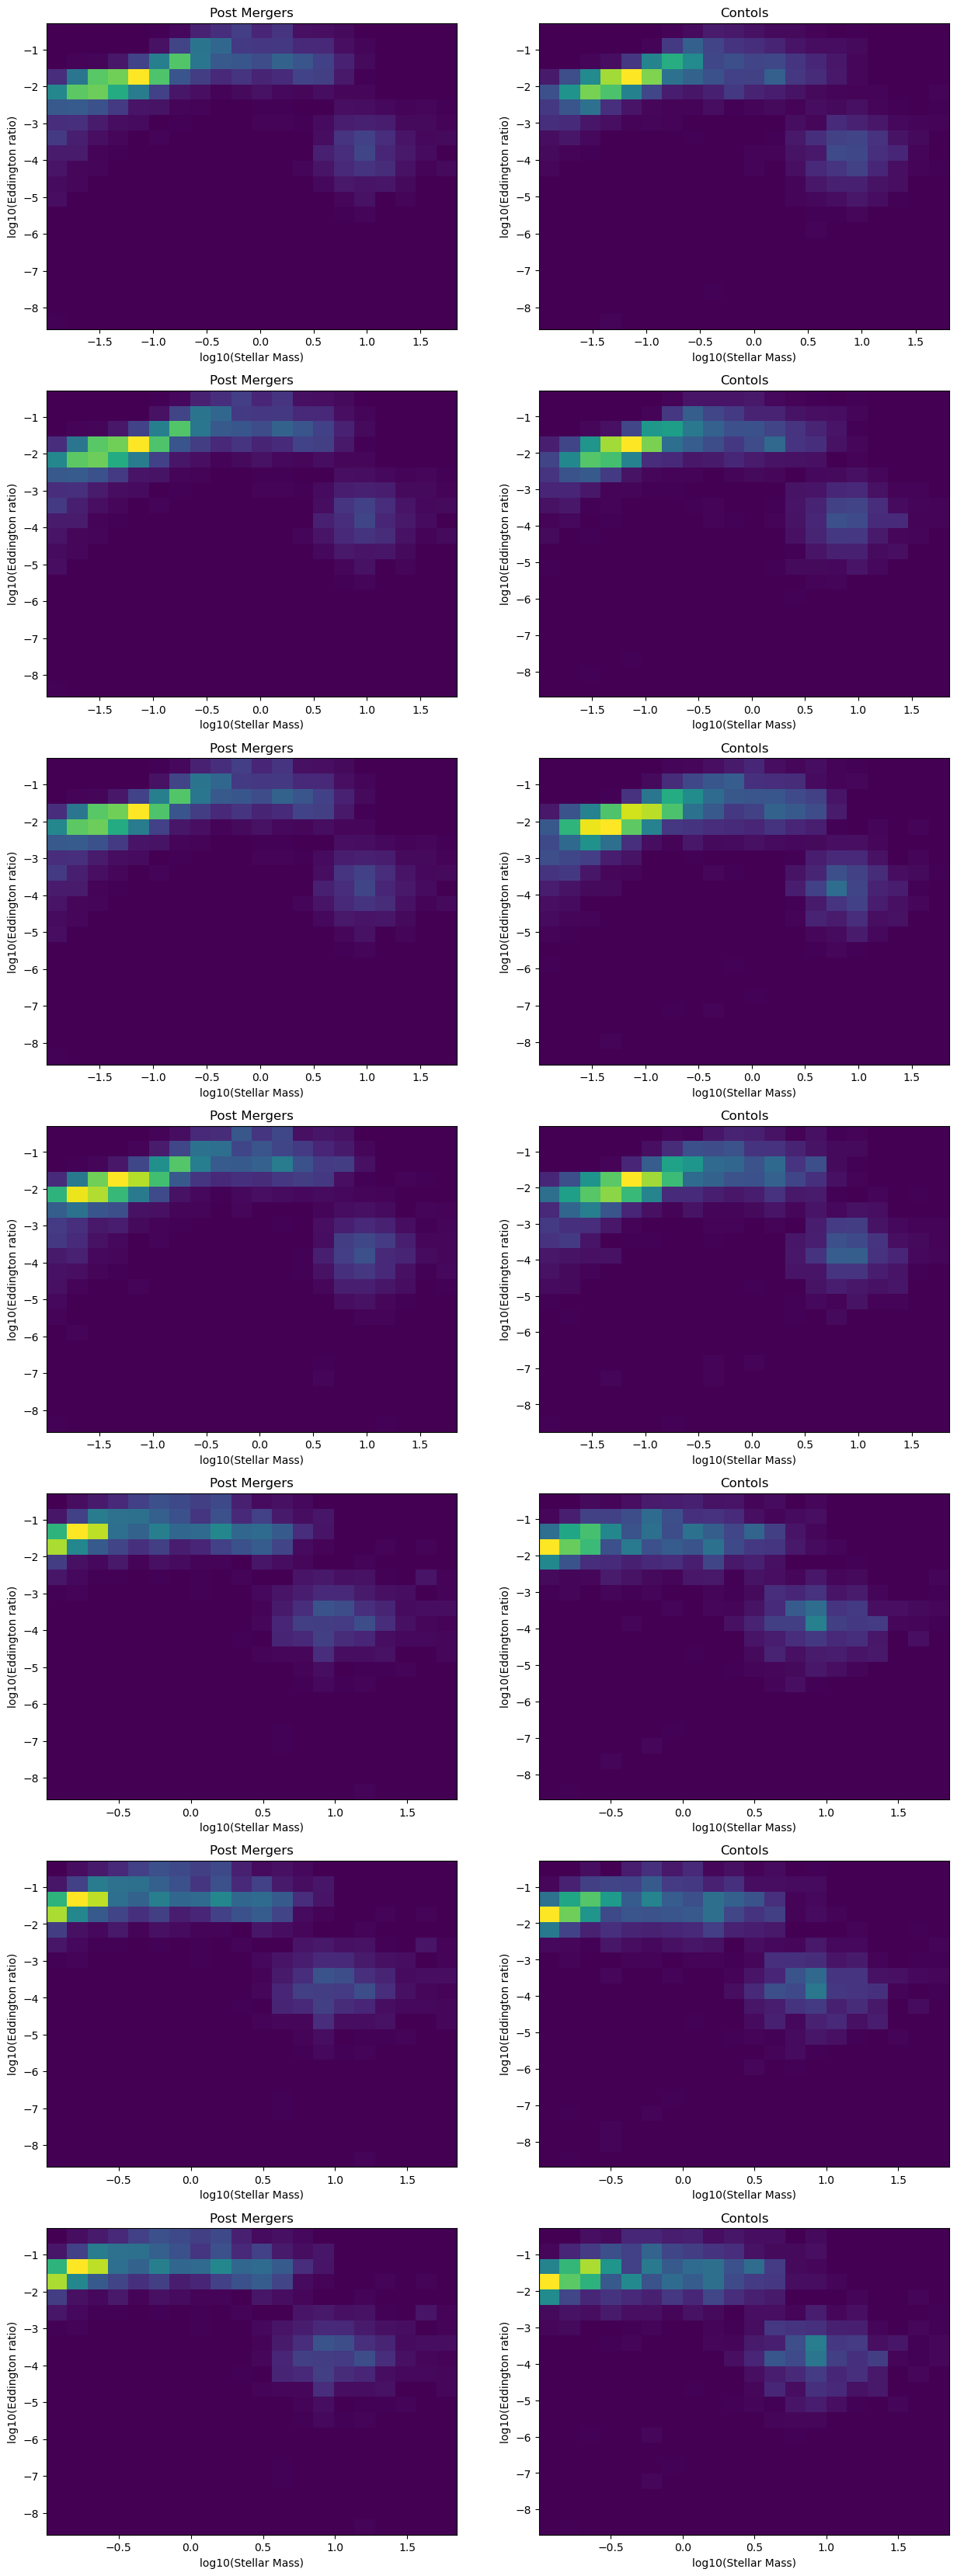

In [92]:
fig = plt.figure(figsize = (15, 6 * len(results_list.values())))
ax = fig.subplots(len(results_list.values()), 2)
for i, results in enumerate(results_list.values()):
    mergers = results.loc[(results['LABEL'] == 1) & (results['Edd_ratio'] > 0)]
    controls = results.loc[(results['LABEL'] == 0) & (results['Edd_ratio'] > 0)]
    ax[i, 0].hist2d(np.log10(mergers.Mstellar), np.log10(mergers.Edd_ratio), bins = 20)
    ax[i, 1].hist2d(np.log10(controls.Mstellar), np.log10(controls.Edd_ratio), bins = 20)
    ax[i, 0].set_title('Post Mergers')
    ax[i, 1].set_title('Contols')
    for axs in ax[i,:]:
        axs.set_xlabel('log10(Stellar Mass)')
        axs.set_ylabel('log10(Eddington ratio)')

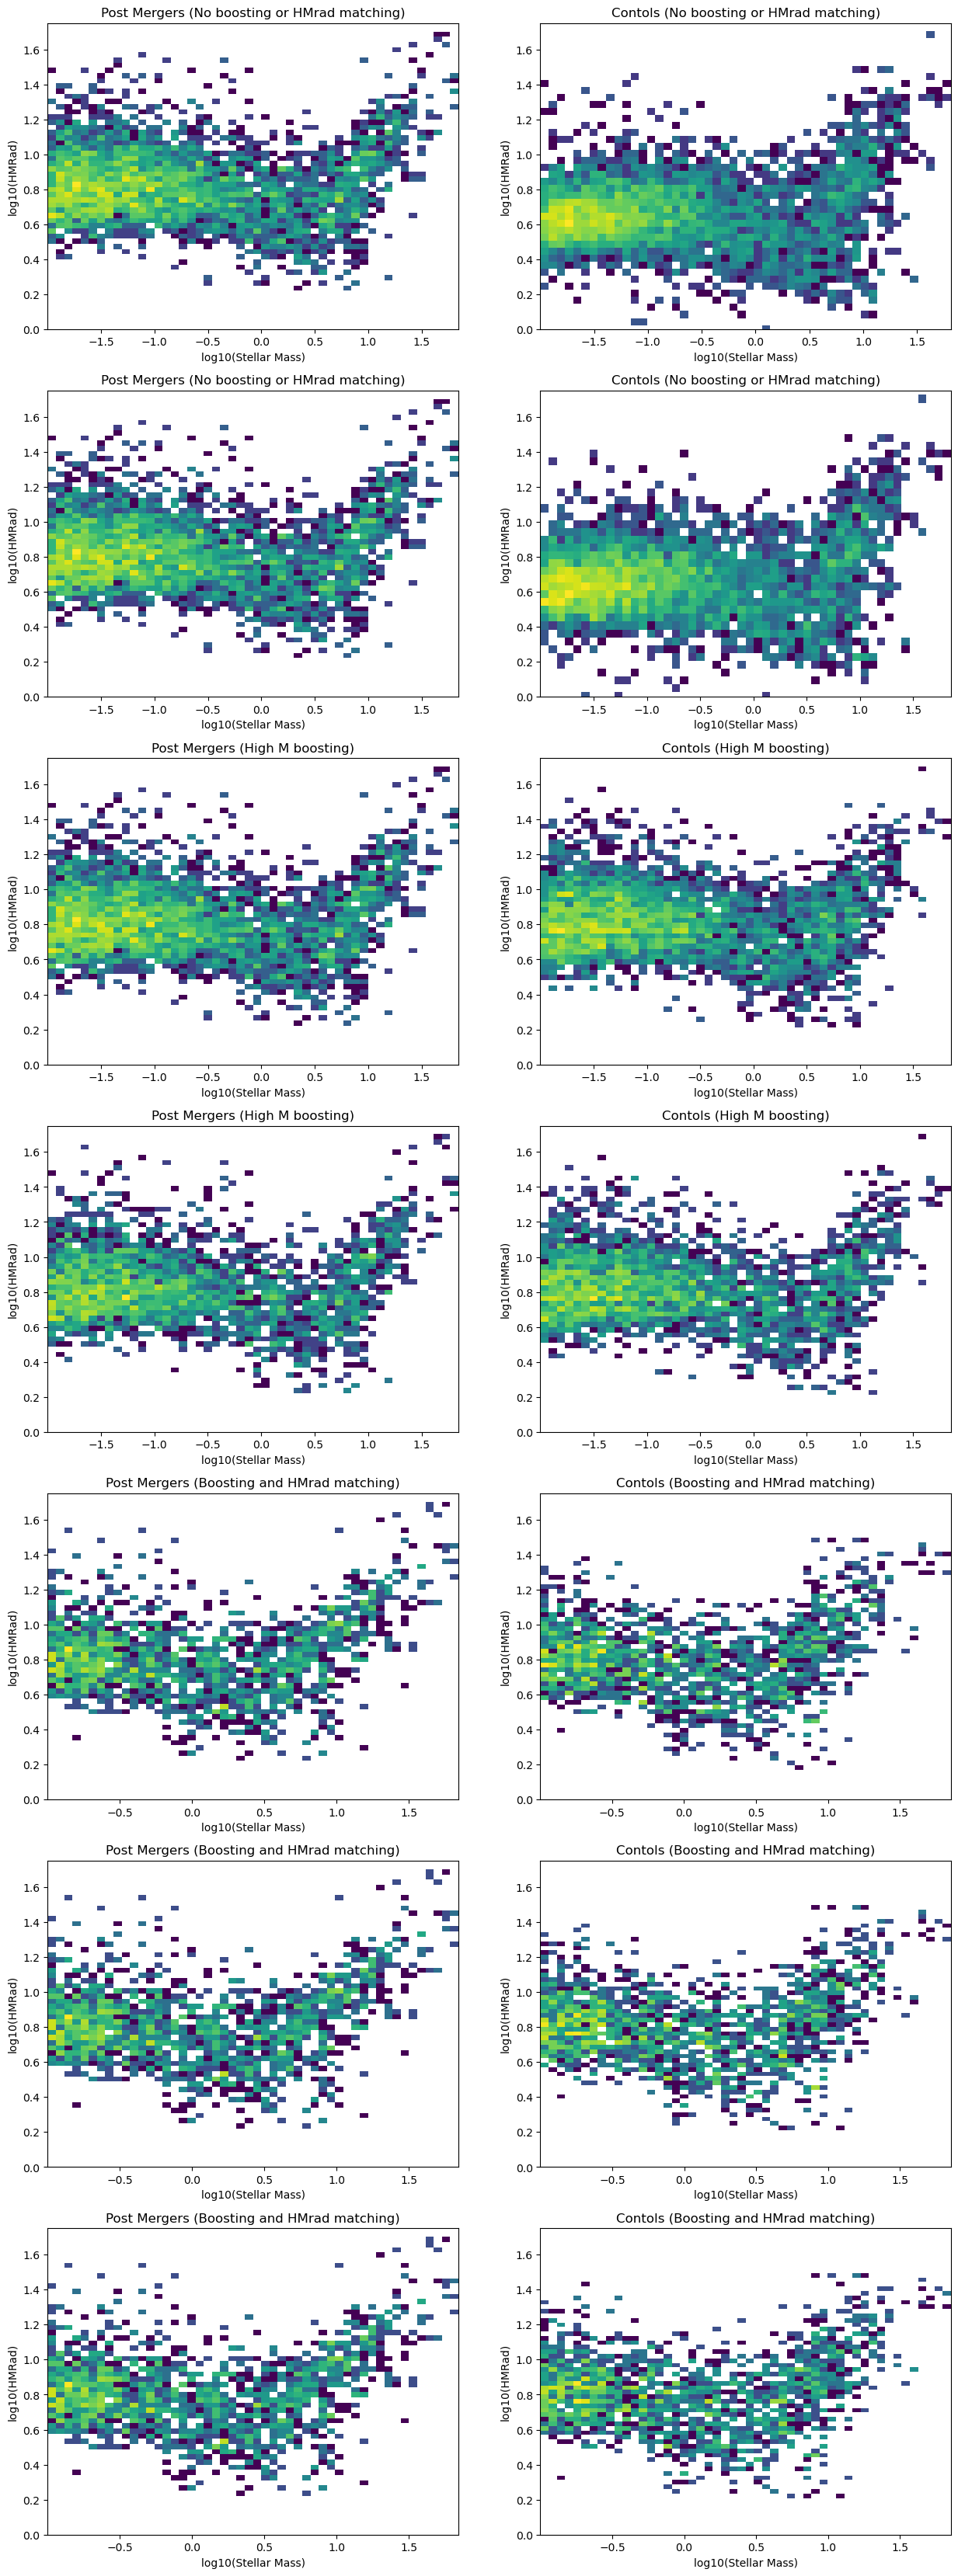

In [109]:
fig = plt.figure(figsize = (15, 6 * len(results_list.values())))
ax = fig.subplots(len(results_list.values()), 2)
for i, results in enumerate(results_list.values()):
    mergers = results.loc[(results['LABEL'] == 1)]
    controls = results.loc[(results['LABEL'] == 0)]
    ax[i, 0].hist2d(np.log10(mergers.Mstellar), np.log10(mergers.HMRad), bins = 50, norm = LogNorm())
    ax[i, 1].hist2d(np.log10(controls.Mstellar), np.log10(controls.HMRad), bins = 50, norm = LogNorm())
    ax[i, 0].set_title('Post Mergers ' + title_labels[i])
    ax[i, 1].set_title('Contols ' + title_labels[i])
    for axs in ax[i,:]:
        axs.set_xlabel('log10(Stellar Mass)')
        axs.set_ylabel('log10(HMRad)')
        axs.set_ylim(0, 1.75)

In [86]:
results = results_list[115]

In [87]:
results.Edd_ratio.max()

0.5168631613862414

In [93]:
results[results.MBH == 0]

SFID  SnapNum   Mstellar  MBH          MDM        Mgas        SFR  \
28     62725.0     46.0   1.943197  0.0     1.354434    0.188301   4.657806   
70     43306.0     44.0  17.251293  0.0  1059.029541  112.708305  83.551910   
204   212047.0     31.0   0.129695  0.0    23.313547    2.680231   7.288965   
212   200273.0     38.0   0.426743  0.0    39.653202    6.369622   6.463806   
223     9978.0     37.0   0.124667  0.0     4.831774    0.552885   3.614540   
...        ...      ...        ...  ...          ...         ...        ...   
6211  102024.0     37.0   1.365727  0.0     2.012691    0.721018  23.385324   
6245  393356.0     50.0   0.325803  0.0    23.388372    3.461214   3.809555   
6318  238018.0     34.0   0.104390  0.0    19.756832    2.313613   3.044451   
6326   25207.0     41.0   3.861434  0.0    40.704800    4.460055  20.111673   
6346  280912.0     35.0   0.148403  0.0    20.257856    2.184140   9.095361   

             Z      HMRad  BHacc  ...  ratio_biggest  dt_biggest  \
28    0.047088   2.921613    0.0  ...       0.000000       0.000   
70    0.016860  17.005877    0.0  ...       0.143912       0.000   
204   0.004561  10.850586    0.0  ...       1.000000       0.000   
212   0.007017  12.124120    0.0  ...       1.000000       0.000   
223   0.008636   6.072176    0.0  ...       0.207042       0.158   
...        ...        ...    ...  ...            ...         ...   
6211  0.029451   2.568220    0.0  ...       0.302176       0.158   
6245  0.007640   8.440137    0.0  ...       0.335159       0.000   
6318  0.003421  15.951656    0.0  ...       0.448779       0.000   
6326  0.027891   3.392354    0.0  ...       0.221164       0.000   
6346  0.005783   9.509470    0.0  ...       0.448779       0.146   

      SFID_biggest  snap_biggest  Redshift   GAS_FRAC  PRED_LABEL  LABEL  \
28             0.0           0.0      1.15   0.096903    0.003310    0.0   
70         43306.0          44.0      1.25   6.533325    0.723552    1.0   
204       212047.0          31.0      2.21  20.665720    0.521913    1.0   
212       200273.0          38.0      1.60  14.926142    0.790102    1.0   
223        25275.0          36.0      1.67   4.434885    0.997151    1.0   
...            ...           ...       ...        ...         ...    ...   
6211      105759.0          36.0      1.67   0.527937    0.761551    1.0   
6245      393356.0          50.0      1.00  10.623653    0.370727    1.0   
6318      238018.0          34.0      1.90  22.163233    0.711679    1.0   
6326       25207.0          41.0      1.41   1.155026    0.904811    1.0   
6346      238018.0          34.0      1.82  14.717591    0.743209    1.0   

      Edd_ratio  Mass/radius**2  
28          NaN        0.227652  
70          NaN        0.059652  
204         NaN        0.001102  
212         NaN        0.002903  
223         NaN        0.003381  
...         ...             ...  
6211        NaN        0.207062  
6245        NaN        0.004574  
6318        NaN        0.000410  
6326        NaN        0.335541  
6346        NaN        0.001641  

[114 rows x 24 columns]

In [94]:
results

SFID  SnapNum  Mstellar       MBH         MDM       Mgas        SFR  \
0     365373.0     37.0  0.120845  0.000148   10.014416   1.467501   2.191807   
1     141285.0     28.0  0.516389  0.000337   26.661966   3.988281  19.466997   
2     132564.0     41.0  8.313909  0.034326  196.144119  22.466230   2.473202   
3     286131.0     47.0  1.480287  0.006745   54.659153   6.827644   9.836741   
4     271344.0     35.0  0.447397  0.000717   22.235662   2.809017   3.935793   
...        ...      ...       ...       ...         ...        ...        ...   
6422  309878.0     49.0  0.579693  0.001701   38.422634   5.415636   7.720203   
6423  397520.0     47.0  0.198501  0.000446   17.730490   2.372656   0.876308   
6424  160315.0     39.0  6.059719  0.021810  131.194000  11.795878  17.212425   
6425   90575.0     39.0  5.065724  0.028201  248.677338  38.273846   7.331684   
6426  347391.0     45.0  0.165617  0.000257   10.559931   1.224513   1.286155   

             Z      HMRad     BHacc  ...  ratio_biggest  dt_biggest  \
0     0.005388  10.990504  0.000057  ...       0.035581       0.158   
1     0.011147   5.422341  0.001497  ...       0.000000       0.000   
2     0.014967   8.774606  0.000153  ...       1.000000       0.209   
3     0.025756   3.250384  0.002582  ...       0.000000       0.000   
4     0.015964   5.219492  0.000757  ...       0.268632       0.146   
...        ...        ...       ...  ...            ...         ...   
6422  0.014678   3.178049  0.001101  ...       0.317353       0.000   
6423  0.014877   3.150937  0.000226  ...       0.192693       0.142   
6424  0.057072   5.789110  0.034988  ...       0.796121       0.168   
6425  0.013606   4.752299  0.001115  ...       0.267948       0.000   
6426  0.009541   4.542595  0.000216  ...       0.000000       0.000   

      SFID_biggest  snap_biggest  Redshift   GAS_FRAC  PRED_LABEL  LABEL  \
0         353613.0          36.0      1.67  12.143667    0.087777    0.0   
1              0.0           0.0      2.58   7.723400    0.097018    0.0   
2         117501.0          40.0      1.41   2.702247    0.839893    1.0   
3              0.0           0.0      1.11   4.612379    0.201714    0.0   
4         258799.0          34.0      1.82   6.278579    0.834435    1.0   
...            ...           ...       ...        ...         ...    ...   
6422      309878.0          49.0      1.04   9.342244    0.674692    1.0   
6423      404757.0          46.0      1.11  11.952848    0.823477    1.0   
6424      149650.0          38.0      1.53   1.946605    0.998458    1.0   
6425       90575.0          39.0      1.53   7.555454    0.853299    1.0   
6426           0.0           0.0      1.21   7.393627    0.022370    0.0   

      Edd_ratio  Mass/radius**2  
0      0.012453        0.001000  
1      0.143225        0.017563  
2      0.000144        0.107982  
3      0.012350        0.140112  
4      0.034063        0.016422  
...         ...             ...  
6422   0.020882        0.057395  
6423   0.016372        0.019993  
6424   0.051760        0.180813  
6425   0.001276        0.224302  
6426   0.027135        0.008026  

[6427 rows x 24 columns]

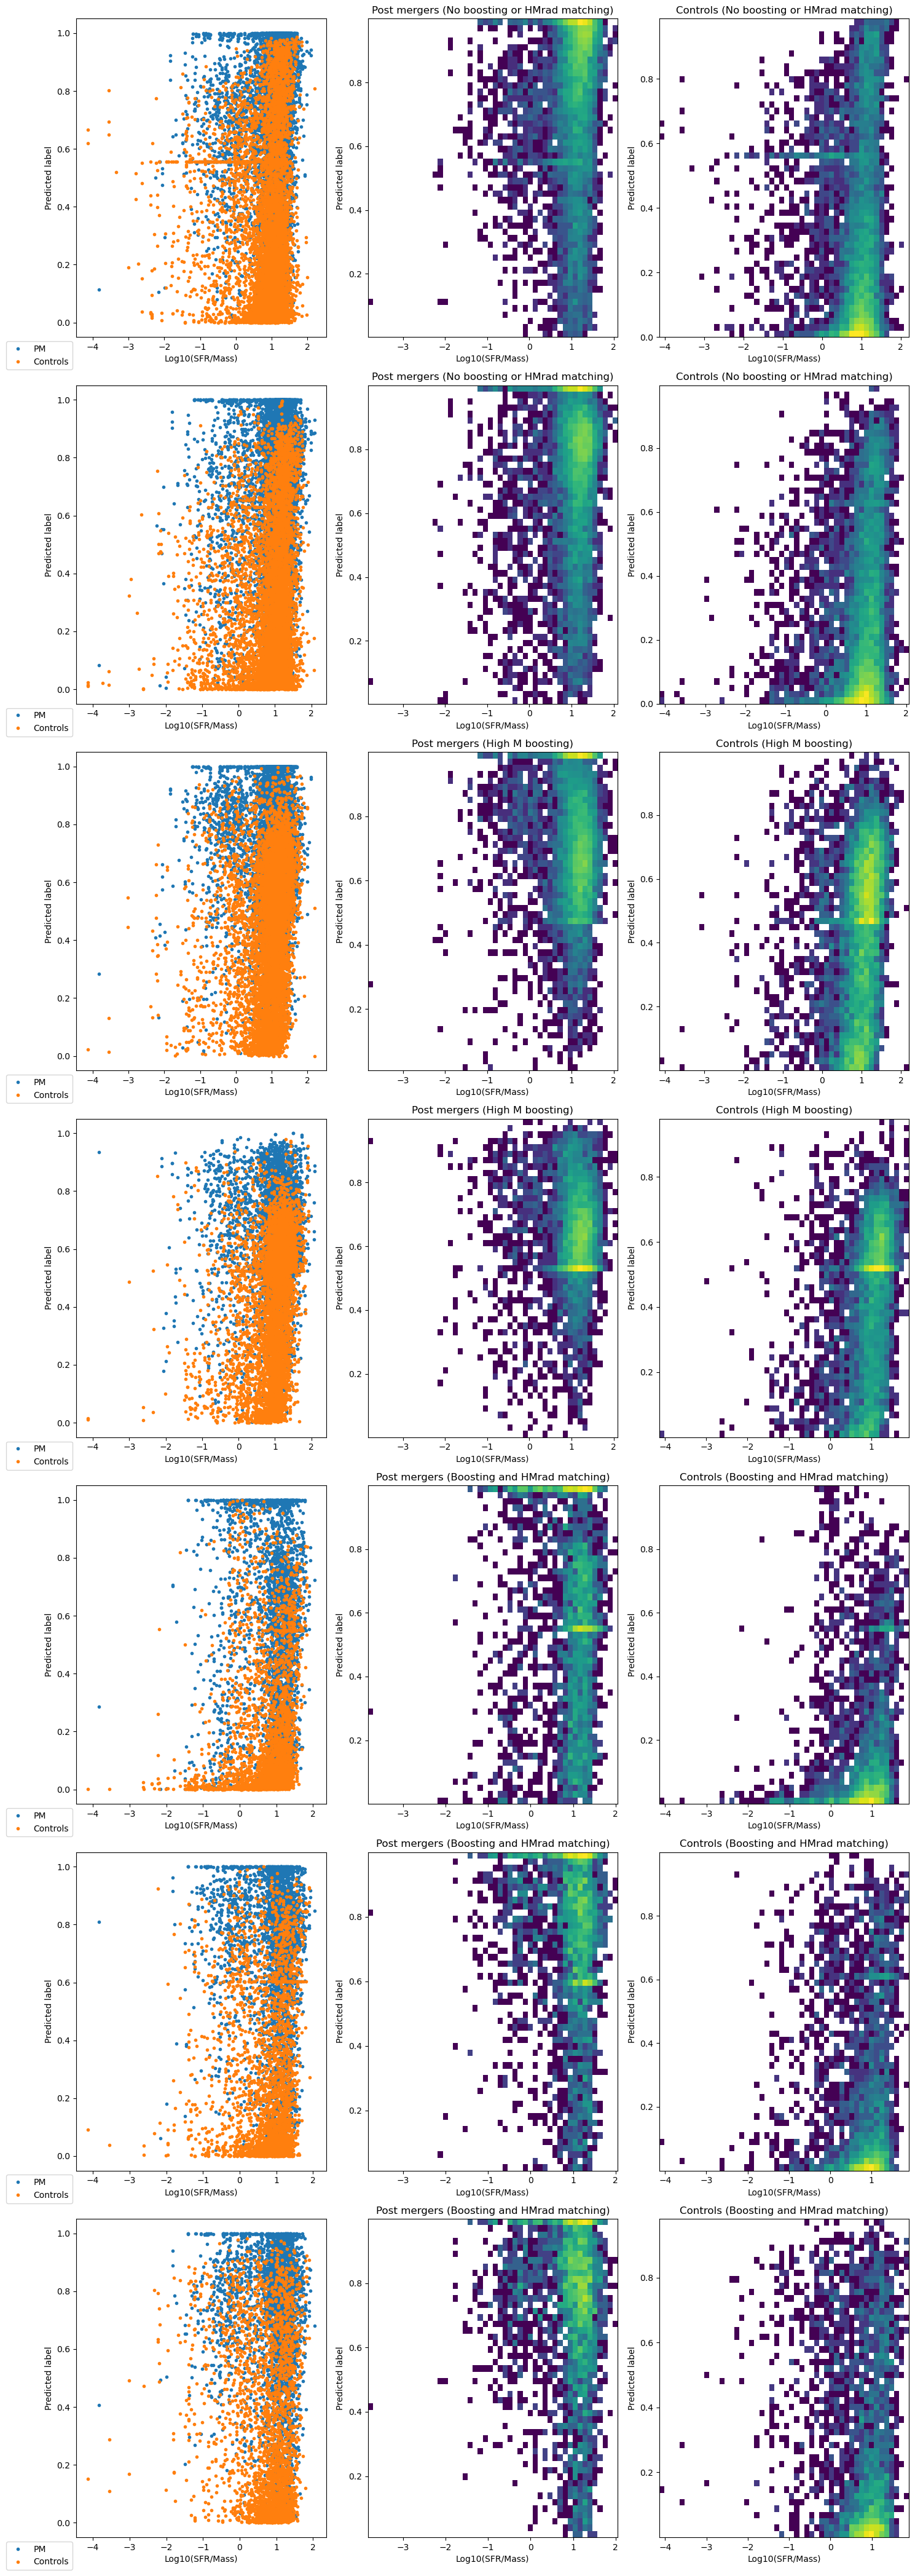

In [5]:
from matplotlib.colors import LogNorm

#results_list = [results_31, results_35, results_42]

param = 'SFR/Mass'
title_labels = {0: '(No boosting or HMrad matching)', 1: '(No boosting or HMrad matching)' , 2: '(High M boosting)', 3: '(High M boosting)', 4: '(Boosting and HMrad matching)', 5: '(Boosting and HMrad matching)', 6: '(Boosting and HMrad matching)'}



fig = plt.figure(figsize = (15, 6 * len(results_list)))
ax = fig.subplots(len(results_list), 3)

for i, results in enumerate(results_list.values()):
    mergers = results.loc[(results['LABEL'] == 1)].reset_index(drop = True)
    controls = results.loc[(results['LABEL'] == 0)].reset_index(drop = True)

    merger_labels = mergers.loc[mergers[param] > 0]['PRED_LABEL']
    control_labels = controls.loc[controls[param] > 0]['PRED_LABEL']
    merger_masses = np.log10(mergers.loc[mergers[param] > 0][param])
    control_masses = np.log10(controls.loc[controls[param] > 0][param])
    
    merger_labels = mergers.loc[mergers[param] > 0]['PRED_LABEL']
    control_labels = controls.loc[controls[param] > 0]['PRED_LABEL']
    merger_masses = np.log10(mergers.loc[mergers[param] > 0][param])
    control_masses = np.log10(controls.loc[controls[param] > 0][param])

    #fig = plt.figure(figsize = (15,5))
    #ax = fig.subplots(1,3)

    ax[i, 0].plot(merger_masses, merger_labels, '.', label = 'PM')
    ax[i, 0].plot(control_masses, control_labels, '.', label = 'Controls')
    ax[i, 0].legend(bbox_to_anchor=(0, 0))
    #ax[0].set_xscale('log')

    ax[i, 1].hist2d(merger_masses,merger_labels,bins=50, norm = LogNorm())
    ax[i, 2].hist2d(control_masses,control_labels,bins=50, norm = LogNorm())

    ax[i, 1].set_title('Post mergers ' + title_labels[i])
    ax[i, 2].set_title('Controls ' + title_labels[i])

    for axs in ax[i, :]:
        axs.set_xlabel('Log10(%s)'%(param))
        axs.set_ylabel('Predicted label')
fig.tight_layout()

In [99]:
run_info

RUN_ID  N_EPOCHS  PIX_SCALE    TH_OPT  TH_OPT_F1   TRA_ACC   VAL_ACC  \
16      42        50         50  0.528529   0.333333  0.781056  0.777202   
32      72        50         50  0.515516   0.417417  0.807815  0.804147   
50      93        50         50  0.594595   0.474474  0.729896  0.717615   
51      94        50         50  0.549550   0.500501  0.726543  0.716965   
65     111        50         50  0.540541   0.385385  0.778143  0.748117   
69     115        50         50  0.287287   0.143143  0.808599  0.803006   
73     117        50         50  0.498498   0.371371  0.797521  0.781494   

    TRA_LOSS  VAL_LOSS  TEST_SIZE_TRN  ...  ratio_merger  dt_merger  \
16  0.459020  0.462425            0.3  ...           0.1       0.20   
32  0.413690  0.418463            0.3  ...           0.1       0.20   
50  0.515368  0.522757            0.3  ...           0.1       0.20   
51  0.527121  0.541571            0.3  ...           0.1       0.15   
65  0.461419  0.488800            0.3  ...           0.1       0.20   
69  0.407806  0.412303            0.3  ...           0.1       0.20   
73  0.428781  0.446625            0.3  ...           0.1       0.20   

    ratio_nonmerger  dt_nonmerger  snap_lower  snap_upper  \
16              0.1           1.0          28          50   
32              0.1           1.0          28          50   
50              0.1           1.0          28          50   
51              0.1           1.5          28          50   
65              0.1           1.0          28          50   
69              0.1           1.0          28          50   
73              0.1           1.0          28          50   

                   gal_params              grab_list_name  boost_massive_gals  \
16                     [None]  grablist_run_00036.parquet               False   
32                     [None]  grablist_run_00072.parquet               False   
50                     [None]  grablist_run_00093.parquet                True   
51                     [None]  grablist_run_00094.parquet                True   
65  [Mstellar, 0.1, 10000000]  grablist_run_00111.parquet                True   
69  [Mstellar, 0.1, 10000000]  grablist_run_00113.parquet                True   
73  [Mstellar, 0.1, 10000000]  grablist_run_00117.parquet                True   

    random_state  
16            42  
32            42  
50            42  
51            42  
65            42  
69            42  
73            42  

[7 rows x 25 columns]